In [1]:
from itertools import combinations, permutations, product
from typing import Dict, Tuple, List, Any, NamedTuple, Callable
import jax
# If you want to perform simulations in float64 you have to call this before any JAX compuation
# jax.config.update('jax_enable_x64', True)

import jax
import jax.numpy as jnp
from jax import Array
import os

os.environ["CHARMM_HOME"] = "/pchem-data/meuwly/boittier/home/charmm"
os.environ["CHARMM_LIB_DIR"] = "/pchem-data/meuwly/boittier/home/charmm/build/cmake"
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import jax
from jax import jit
import jax.numpy as jnp
import ase.calculators.calculator as ase_calc
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

import sys
import e3x
import jax
import numpy as np
import optax
import orbax
from pathlib import Path
import pandas as pd

# Add custom path
sys.path.append("/pchem-data/meuwly/boittier/home/pycharmm_test")
import physnetjax

sys.path.append("/pchem-data/meuwly/boittier/home/dcm-lj-data")
from pycharmm_lingo_scripts import script1, script2, script3, load_dcm

from physnetjax.data.data import prepare_datasets
from physnetjax.training.loss import dipole_calc
from physnetjax.models.model import EF
from physnetjax.training.training import train_model  # from model import dipole_calc
from physnetjax.data.batches import (
    _prepare_batches as prepare_batches,
)  # prepare_batches, prepare_datasets

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

data_key, train_key = jax.random.split(jax.random.PRNGKey(42), 2)

from pathlib import Path

from physnetjax.calc.helper_mlp import get_ase_calc


def parse_non_int(s):
    return "".join([_ for _ in s if _.isalpha()]).lower().capitalize()


read_parameter_card = """
read parameter card
* methanol
*
NONBONDED
CG321    0.0       {CG321EP:.4f}     {CG321RM:.4f}   0.0 -0.01 1.9 ! alkane (CT2), 4/98, yin, adm jr, also used by viv
CLGA1    0.0       {CLGA1EP:.4f}    {CLGA1RM:.4f} ! CLET, DCLE, chloroethane, 1,1-dichloroethane
HGA2     0.0       {HGA2EP:.4f}    {HGA2RM:.4f} ! alkane, yin and mackerell, 4/98
END
"""
# HGA2     0.0       -0.0200     1.3400 ! alkane, yin and mackerell, 4/98


NATOMS = 10

model = EF(
    # attributes
    features=128,
    max_degree=0,
    num_iterations=5,
    num_basis_functions=64,
    cutoff=10.0,
    max_atomic_number=18,
    charges=True,
    natoms=NATOMS,
    total_charge=0,
    n_res=3,
    zbl=False,
    debug=False,
)


import pycharmm

import pycharmm
import pycharmm.generate as gen
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.nbonds as nbonds
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.read as read
import pycharmm.write as write
import pycharmm.settings as settings
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.select as select
import pycharmm.shake as shake

from pycharmm.lib import charmm as libcharmm


import ase
from ase.io import read as read_ase
from ase import visualize
from ase.visualize import view


from scipy.optimize import minimize

ev2kcalmol = 1 / (ase.units.kcal / ase.units.mol)

CG321EP = -0.0560
CG321RM = 2.0100
CLGA1EP = -0.3430
CLGA1RM = 1.9100
HGA2EP =  -0.0200  
HGA2RM = 1.3400 

def set_pycharmm_xyz(atom_positions):
    xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
    coor.set_positions(xyz)


def capture_neighbour_list():
    # Print something
    distance_command = """
    open unit 1 write form name total.dmat
    
    COOR DMAT SINGLE UNIT 1 SELE ALL END SELE ALL END
    
    close unit 1"""
    _ = pycharmm.lingo.charmm_script(distance_command)

    with open("total.dmat") as f:
        output_dmat = f.read()

    atom_number_type_dict = {}
    atom_number_resid_dict = {}

    pair_distance_dict = {}
    pair_resid_dict = {}

    for _ in output_dmat.split("\n"):
        if _.startswith("*** "):
            _, n, resid, resname, at, _ = _.split()

            n = int(n.split("=")[0]) - 1
            atom_number_type_dict[n] = at
            atom_number_resid_dict[n] = int(resid) - 1

    for _ in output_dmat.split("\n"):
        if _.startswith("  "):
            a, b, dist = _.split()
            a = int(a) - 1
            b = int(b) - 1
            dist = float(dist)
            if atom_number_resid_dict[a] < atom_number_resid_dict[b]:
                pair_distance_dict[(a, b)] = dist
                pair_resid_dict[(a, b)] = (
                    atom_number_resid_dict[a],
                    atom_number_resid_dict[b],
                )

    return {
        "atom_number_type_dict": atom_number_type_dict,
        "atom_number_resid_dict": atom_number_resid_dict,
        "pair_distance_dict": pair_distance_dict,
        "pair_resid_dict": pair_resid_dict,
    }


def get_forces_pycharmm():
    positions = coor.get_positions()
    force_command = """coor force sele all end"""
    _ = pycharmm.lingo.charmm_script(force_command)
    forces = coor.get_positions()
    coor.set_positions(positions)
    return forces


def view_atoms(atoms):
    return view(atoms, viewer="x3d")


from itertools import combinations


def dimer_permutations(n_mol):
    dimer_permutations = list(combinations(range(n_mol), 2))
    return dimer_permutations


def calc_pycharmm_dimers(n_mol=20, n_atoms=5, forces=False):
    RANGE = len(dimer_permutations(n_mol))

    ele_energies = np.zeros(RANGE)
    evdw_energies = np.zeros(RANGE)
    mm_forces = np.zeros((RANGE, n_atoms * n_mol, 3))

    for i, (a, b) in enumerate(dimer_permutations(20)):
        reset_block_no_internal()
        a += 1
        b += 1
        block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
        """
        _ = pycharmm.lingo.charmm_script(block)
        # print(_)
        energy.show()
        if forces:
            f = get_forces_pycharmm().to_numpy()
            mm_forces[i] = f

        evdw = energy.get_vdw()
        evdw_energies[i] = evdw
        e = energy.get_elec()
        ele_energies[i] = e

    return {
        "ele_energies": ele_energies,
        "evdw_energies": evdw_energies,
        "mm_forces": mm_forces,
    }


def reset_block():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


def reset_block_no_internal():
    block = f"""BLOCK 
        CALL 1 SELE ALL END
          COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0 
        END
        """
    _ = pycharmm.lingo.charmm_script(block)


reset_block_no_internal()


import MDAnalysis as mda


def load_pdb_data(pdb_file):
    # loaded_pdb = mda.coordinates.PDB.PDBReader(pdb_file)
    # loaded_pdb = mda.topology.PDBParser.PDBParser(pdb_file)
    
    atypes = psf.get_atype()
    atc = pycharmm.param.get_atc()
    residues = psf.get_res()
    psf.get_natom()
    # nl_info = capture_neighbour_list()

    # TODO: this assumes a pure system, need to update
    atoms_per_res = int(len(atypes) / len(residues))
    n_res = len(residues)
    resids = np.array([[i] * atoms_per_res for i in range(n_res)]).flatten()
    u = mda.Universe(pdb_file)
    atom_names = [s for s in list(u.atoms.names)]
    atom_positions = list(u.atoms.positions)
    atomic_numbers = np.array(
        [ase.data.atomic_numbers[parse_non_int(s)] for s in atom_names]
    )
    mda_resids = [s for s in list(u.atoms.resids)]
    mda_res_at_dict = {
        (a - 1, b): i for i, (a, b) in enumerate(zip(mda_resids, atom_names))
    }
    charmm_res_at_dict = {(a, b): i for i, (a, b) in enumerate(zip(resids, atypes))}
    an_charmm_res_at_dict = {v: k for k, v in charmm_res_at_dict.items()}
    an_mda_res_at_dict = {v: k for k, v in mda_res_at_dict.items()}
    atom_positions = np.array(atom_positions)
    reorder = np.array(
        [charmm_res_at_dict[an_mda_res_at_dict[i]] for i in range(len(atom_positions))]
    )
    atom_positions = atom_positions[reorder]
    atomic_numbers = atomic_numbers[reorder]

    return {
        "atom_names": atom_names,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
        "mda_resids": mda_resids,
        "mda_res_at_dict": mda_res_at_dict,
        "charmm_res_at_dict": charmm_res_at_dict,
        "an_charmm_res_at_dict": an_charmm_res_at_dict,
        "an_mda_res_at_dict": an_mda_res_at_dict,
        "atom_positions": atom_positions,
        "reorder": reorder,
        "atom_positions": atom_positions,
        "atomic_numbers": atomic_numbers,
    }


def get_data_mda(fn):
    pdb_file = data_path / "dcmk" / fn
    pdb_data_mda = load_pdb_data(pdb_file)
    return pdb_data_mda


epsilon = 10 ** (-6)
from e3x.nn import smooth_switch, smooth_cutoff


def combine_with_sigmoid(
    r,
    mm_energy,
    ml_energy,
    dif=10 ** (-6),
    MM_CUTON=5.0,
    MM_CUTOFF=10.0,
    BUFFER=0.1,
    debug=False,
):
    ML_CUTOFF = MM_CUTON - dif
    charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
    charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
    # remove any sigularities
    charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)

    ml_scale = 1 - abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    ml_contrib = ml_scale * ml_energy

    mm_contrib = charmm_on_scale * mm_energy
    mm_contrib = mm_contrib * charmm_off_scale

    return mm_contrib, ml_contrib, charmm_off_scale, charmm_on_scale, ml_scale


def indices_of_pairs(a, b, n_atoms=5, n_mol=20):
    assert a < b, "by convention, res a must have a smaller index than res b"
    assert a >= 1, "res indices can't start from 1"
    assert b >= 1, "res indices can't start from 1"
    assert a != b, "pairs can't contain same residue"
    return np.concatenate(
        [
            np.arange(0, n_atoms, 1) + (a - 1) * n_atoms,
            np.arange(0, n_atoms, 1) + (b - 1) * n_atoms,
        ]
    )


def indices_of_monomer(a, n_atoms=5, n_mol=20):
    assert a < (n_mol + 1), "monomer index outside total n molecules"
    return np.arange(0, n_atoms, 1) + (a - 1) * n_atoms


def calc_physnet_via_idx_list(all_coordinates, all_idxs, calculator):
    RANGE = len(all_idxs)
    ml_energies = np.zeros(RANGE)
    ml_forces = np.zeros((RANGE, len(all_idxs[0]), 3))

    for i, idxs in enumerate(all_idxs):
        # set positions
        calculator.set_positions(all_coordinates[idxs])

        ml_energies[i] = calculator.get_potential_energy()
        ml_forces[i] = calculator.get_forces()

    return {"ml_energies": ml_energies, "ml_forces": ml_forces}


def get_dimer_distances(dimer_idxs, all_monomer_idxs, R):
    out_dists = np.zeros(len(dimer_idxs))
    for i, (a, b) in enumerate(dimer_idxs):
        a = all_monomer_idxs[a][0]  # just distance to first atom in the molecule...
        b = all_monomer_idxs[b][0]  # TODO: generalize...
        out_dists[i] = np.linalg.norm(R[a] - R[b])

    return out_dists


def setup_ase_atoms(atomic_numbers, positions, n_atoms):
    """Create and setup ASE Atoms object with centered positions"""
    Z = [_ for i, _ in enumerate(atomic_numbers) if i < n_atoms]
    R = np.array([_ for i, _ in enumerate(positions) if i < n_atoms])
    atoms = ase.Atoms(Z, R)
    # translate to center of mass
    # atoms.set_positions(R - R.T.mean(axis=1))
    return atoms


def create_physnet_calculator(params, model, atoms, ev2kcalmol):
    """Create PhysNet calculator with specified parameters"""
    calc = get_ase_calc(
        params,
        model,
        atoms,
        conversion={"energy": ev2kcalmol, "dipole": 1, "forces": ev2kcalmol},
    )
    atoms.calc = calc
    return atoms


def initialize_models(restart_path, N_ATOMS_MONOMER):
    """Initialize monomer and dimer models from restart"""
    restart = get_last(restart_path)

    # Setup monomer model
    params, monomer_model = get_params_model(restart)
    monomer_model.natoms = N_ATOMS_MONOMER

    # Setup dimer model
    params, dimer_model = get_params_model(restart)
    dimer_model.natoms = N_ATOMS_MONOMER * 2

    return params, monomer_model, dimer_model


def get_rmse_mae(energy, ref_energy):
    rmse = np.sqrt(np.mean((energy - ref_energy) ** 2))
    mae = np.mean(np.abs(energy - ref_energy))
    return rmse, mae


def print_energy_comparison(mmml_energy, charmm, ref_energy):
    """Print comparison of energies with reference data"""

    print("comb")
    print(mmml_energy, ref_energy, abs(mmml_energy - ref_energy))

    print("charmm")
    print(charmm, ref_energy, abs(charmm - ref_energy))


def calculate_E_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM energies"""
    summed_ml_intE = dimer_results["ml_energies"] - monomer_results["ml_energies"][
        np.array(dimer_idxs)
    ].sum(axis=1)
    summed_mm_intE = result["ele_energies"] + result["evdw_energies"]
    return summed_ml_intE, summed_mm_intE

def calculate_F_pair(dimer_results, monomer_results, dimer_idxs, result):
    """Calculate and combine ML and MM forces"""
    mono = monomer_results["ml_forces"][
        np.array(dimer_idxs)
    ]
    print(mono.shape)
    a,b,c,d = mono.shape
    mono = mono.reshape(a, b*c, d)
    summed_ml_intF = dimer_results["ml_forces"] - mono
    summed_mm_intF = result["mm_forces"]
    return summed_ml_intF, summed_mm_intF

def get_fnkey(fn):
    fnkey = str(fn).split("/")[-1].split(".")[0].upper()
    fnkey = "_".join(fnkey.split("_")[:3])
    return fnkey

def calc_energies_forces(
    fn, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    pdb_data_mda = get_data_mda(fn)
    atomic_numbers, atom_positions = (
        pdb_data_mda["atomic_numbers"],
        pdb_data_mda["atom_positions"],
    )
    set_pycharmm_xyz(atom_positions)
    energy.show()

    ase_atom_full_system = ase.Atoms(atomic_numbers, atom_positions)
    
    result = None
    summed_2body = None
    mmml_energy = None
    charmm = None

    if DO_MM:
        # Calculate CHARMM energies and forces first
        result = calc_pycharmm_dimers(forces=True)
        summed_2body = result["mm_forces"].sum(axis=0)
        mm_forces = result["mm_forces"]

    all_coordinates = ase_atom_full_system.get_positions()
    dimer_idxs = dimer_permutations(20)

    dimer_pair_c_c_distances = get_dimer_distances(
        dimer_idxs, all_monomer_idxs, all_coordinates
    )

    if DO_ML:
        dimer_results = calc_physnet_via_idx_list(
            all_coordinates, all_dimer_idxs, ase_atoms_dimer
        )

        monomer_results = calc_physnet_via_idx_list(
            all_coordinates, all_monomer_idxs, ase_atoms_monomer
        )

        # Calculate ML and MM energies
        summed_ml_intE, summed_mm_intE = calculate_E_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

        summed_ml_intF, summed_mm_intF = calculate_F_pair(
            dimer_results, monomer_results, dimer_idxs, result
        )

    if DO_MM and DO_ML:
        combined_with_switches = combine_with_sigmoid(
            dimer_pair_c_c_distances,
            summed_mm_intE,
            summed_ml_intE,
            MM_CUTON=MM_CUTON,
            MM_CUTOFF=MM_CUTOFF,
            BUFFER=BUFFER,
        )
        (
            mm_contrib,
            ml_contrib,
            charmm_off_scale,
            charmm_on_scale,
            ml_scale,
        ) = combined_with_switches

        mmml_energy = float(ml_contrib.sum() + mm_contrib.sum())
        charmm = float(summed_mm_intE.sum())
    else:
        mmml_energy = float(summed_ml_intE.sum())
        charmm = float(summed_mm_intE.sum())

    print(summed_ml_intE.shape, summed_mm_intE.shape)

    mm_forces = summed_mm_intF
    ml_forces = summed_ml_intF


    indices = np.array(all_dimer_idxs).flatten()[:, None].repeat(3, axis=1) + np.array([0, mm_forces.shape[1],  2*mm_forces.shape[1]])
    flattened_ml_dimers = ml_forces.reshape(-1, 3).flatten()
    # indices = np.repeat(np.array(all_dimer_idxs).flatten(), 3)
    mmml_forces = jax.ops.segment_sum(flattened_ml_dimers, indices.flatten()).reshape(mm_forces.shape[1], 3)
    
    # mmml_forces = (mm_forces, ml_forces)


    output_dict = {
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }

    return output_dict

def compare_energies(
    fn,  df, DO_ML=True, DO_MM=True, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.1
):
    energy_forces_dict = calc_energies_forces(fn, DO_ML=DO_ML, DO_MM=DO_MM, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
    mmml_energy = energy_forces_dict["mmml_energy"]
    charmm = energy_forces_dict["charmm"]
    mm_forces = energy_forces_dict["mm_forces"]
    ml_forces = energy_forces_dict["ml_forces"]
    mmml_forces = energy_forces_dict["mmml_forces"]

    # print(fn)
    fnkey = get_fnkey(fn)
    # print(fnkey)
    # print(df)
    if fnkey in df["key"].values:
        df = df[df["key"] == fnkey]
        # print(df)
        ref_energy = df.iloc[0]["Formation Energy (kcal/mol)"]
        if DO_MM:
            err_mmml = mmml_energy - ref_energy
            err_charmm = charmm - ref_energy
        else:
            err_mmml = mmml_energy - ref_energy
            err_charmm = None
    else:
        ref_energy = None
        err_mmml = None
        err_charmm = None

    results_dict = {
        "ref_energy": ref_energy,
        "mmml_energy": mmml_energy,
        "charmm": charmm,
        "err_mmml": err_mmml,
        "err_charmm": err_charmm,
        "mm_forces": mm_forces,
        "ml_forces": ml_forces,
        "mmml_forces": mmml_forces,
    }
    return results_dict


def set_param_card(CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM, HGA2EP=HGA2EP, HGA2RM=HGA2RM):
    cmd = "PRNLev 5\nWRNLev 5"
    param_card = read_parameter_card.format(
        CG321EP=CG321EP, CG321RM=CG321RM, CLGA1EP=CLGA1EP, CLGA1RM=CLGA1RM, HGA2EP=HGA2EP, HGA2RM=HGA2RM
    )
    print(param_card)
    pycharmm.lingo.charmm_script(param_card)
    cmd = "PRNLev 0\nWRNLev 0"
    pycharmm.lingo.charmm_script(cmd)


def get_loss_terms(fns, MM_CUTON=6.0, MM_CUTOFF=10.0, BUFFER=0.01, MM_lambda=1.0, ML_lambda=0.0, DO_MM=True, DO_ML=True):
    import time

    start = time.time()
    err_mmml_list = []
    err_charmm_list = []
    for fn in fns:
        results_dict = compare_energies(fn, df, DO_MM=DO_MM, DO_ML=DO_ML, MM_CUTON=MM_CUTON, MM_CUTOFF=MM_CUTOFF, BUFFER=BUFFER)
        err_mmml_list.append(results_dict["err_mmml"])
        err_charmm_list.append(results_dict["err_charmm"])
        print(
            "{} {:.1f} {:.1f} {:.1f} {:.1f} {:.1f}".format(
                fn.stem,
                results_dict["ref_energy"],
                results_dict["mmml_energy"],
                results_dict["charmm"],
                results_dict["err_mmml"],
                results_dict["err_charmm"],
            )
        )

    end = time.time()
    print("Finished")
    print("Time taken", end - start)
    print("--------------------------------")
    err_mmml_list = np.array(err_mmml_list)
    err_charmm_list = np.array(err_charmm_list)

    print("RMSE MMML", np.sqrt(np.mean(err_mmml_list**2)))
    print("MAE MMML", np.mean(np.abs(err_mmml_list)))
    print("RMSE Charmm", np.sqrt(np.mean(err_charmm_list**2)))
    print("MAE Charmm", np.mean(np.abs(err_charmm_list)))

    loss = MM_lambda * np.mean(err_mmml_list**2) + ML_lambda * np.mean(err_charmm_list**2)
    return loss, err_mmml_list, err_charmm_list

def get_loss_fn(train_filenames, DO_ML=True, DO_MM=True, NTRAIN=20, MM_CUTON=6.0, MM_lambda=1.0, ML_lambda=0.0):
    def loss_fn(x0):
        print("Starting")
        # random_indices = np.random.randint(0, len(train_filenames),6)
        fns = [train_filenames[i] for i in range(NTRAIN)]
        CG321EP, CG321RM, CLGA1EP, CLGA1RM = x0[:4]
        set_param_card(CG321EP, CG321RM, CLGA1EP, CLGA1RM)
        loss, _, _ = get_loss_terms(fns, MM_CUTON=MM_CUTON, MM_lambda=MM_lambda, ML_lambda=ML_lambda, DO_MM=DO_MM, DO_ML=DO_ML)
        print("Loss", loss)
        return loss
    return loss_fn


def ep_scale_loss(x0):
    print("Starting")
    random_indices = np.random.randint(0, len(train_filenames), 4)
    fns = [train_filenames[i] for i in random_indices]
    ep_scale = float(x0)
    set_param_card(CG321EP * ep_scale, CG321RM, CLGA1EP * ep_scale, CLGA1RM)
    loss, _, _ = get_loss_terms(fns)
    print("Loss", loss)
    return loss

def create_initial_simplex(x0, delta=0.0001):
    initial_simplex = np.zeros((len(x0) + 1, len(x0)))
    initial_simplex[0] = x0  # First point is x0
    for i in range(len(x0)):
        initial_simplex[i + 1] = x0.copy()
        initial_simplex[i + 1, i] += delta  # Add small step in dimension i
    return initial_simplex


def optimize_params_simplex(x0, bounds, 
loss, method="Nelder-Mead", maxiter=100, xatol=0.0001, fatol=0.0001):
    initial_simplex = create_initial_simplex(x0)
    res = minimize(
        loss,
        x0=x0,
        method="Nelder-Mead",
        bounds=bounds,
        options={
            "xatol": 0.0001,  # Absolute tolerance on x
            "fatol": 0.0001,  # Absolute tolerance on function value
            "initial_simplex": initial_simplex,
            "maxiter": 100,
        },
    )  # Initial simplex with steps of 0.0001

    print(res)
    return res
    
def get_bounds(x0, scale=0.1):
    b= [(x0[i] * (1-scale), x0[i] * (1+scale)) if x0[i] > 0 else (x0[i] * (1+scale), x0[i] * (1-scale)) 
    for i in range(len(x0)) ]
    return b

from physnetjax.restart.restart import get_last, get_files, get_params_model
from physnetjax.analysis.analysis import plot_stats

def get_block(a,b):
    block = f"""BLOCK
CALL 1 SELE .NOT. (RESID {a} .OR. RESID {b}) END
CALL 2 SELE (RESID {a} .OR. RESID {b}) END
COEFF 1 1 0.0
COEFF 2 2 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
COEFF 1 2 0.0
END
"""
    return block


# @jit
# def switch_MM(    X,
#     mm_energy,
#     dif=10 ** (-6),
#     MM_CUTON=6.0,
#     MM_CUTOFF=10.0,
#     BUFFER=0.1,
#     debug=False,
# ):
#     r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:10].T.mean(axis=1))
#     ML_CUTOFF = MM_CUTON - dif
#     charmm_on_scale = smooth_switch(r, x0=ML_CUTOFF, x1=MM_CUTON)
#     charmm_off_scale = smooth_cutoff(r - MM_CUTON, cutoff=MM_CUTOFF - MM_CUTON)
#     # remove any sigularities
#     charmm_off_scale = jax.numpy.nan_to_num(charmm_off_scale, posinf=1)
#     mm_contrib = charmm_on_scale * mm_energy * charmm_off_scale
#     return mm_contrib



# @jit
# def switch_ML(X,
#     ml_energy,
#     dif=10 ** (-6),
#     MM_CUTON=6.0,
#     MM_CUTOFF=10.0,
#     BUFFER=1,
#     debug=False,
# ):
#     # Calculate center-of-mass distance between monomers
#     r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:10].T.mean(axis=1))
    
#     # Add small epsilon to avoid division by zero
#     eps = 1e-10
#     r = r + eps
    
#     ML_CUTOFF = MM_CUTON - dif
#     ml_scale = 1 - jnp.abs(smooth_switch(r, x0=ML_CUTOFF - BUFFER, x1=ML_CUTOFF))
    
#     # Ensure scale is between 0 and 1
#     ml_scale = jnp.clip(ml_scale, 0.0, 1.0)
    
#     ml_contrib = ml_scale * ml_energy
#     return ml_contrib

# switch_ML_grad = jax.grad(switch_ML)
# switch_MM_grad = jax.grad(switch_MM)


# @jit
# def combine_with_sigmoid_E(
#     X,
#     mm_energy,
#     ml_energy,
#     dif=10 ** (-6),
#     MM_CUTON=6.0,
#     MM_CUTOFF=10.0,
#     BUFFER=0.1,
#     debug=False,
# ):
#     ml_contrib = switch_ML(X,ml_energy)
#     mm_contrib = switch_ML(X,mm_energy)
#     return mm_contrib + ml_contrib


# # DATA
# ###################################################################
# data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
# df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
# df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper())

# print(df)




[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


2025-04-10 22:52:07.997145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744318328.019023  455187 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744318328.025852  455187 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 22:52:17.888698: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  
 CHARMM>     BLOCK
 WARNING from DECODI -- Zero length string being converted to 0
 Block structure initialized with   3 blocks.
 All atoms have been assigned to block 1.
 All interaction coefficients have been set to unity.
  Setting number of block exclusions nblock_excldPairs=0
  
  BLOCK>            CALL 1 SELE ALL END
 SELRPN>      0 atoms have been selected out of      0
 The selected atoms have been reassigned to block   1
  
  BLOCK>              COEFF 1 1 1.0 BOND 0.0 ANGL 0.0 DIHEdral 0.0
  
  BLOCK>            END
 Matrix of Interaction Coefficients
 
    1.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of BOND Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of ANGLE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of DIHE Interaction Coefficients
 
    0.00000
    1.00000   1.00000
    1.00000   1.00000   1.00000
 Matrix of CROSS Interaction Coeff

# ...

In [11]:
# R = coor.get_positions().to_numpy()

# # System constants
# ATOMS_PER_MONOMER: int = 5  # Number of atoms in each monomer
# MAX_ATOMS_PER_SYSTEM: int = 10  # Maximum atoms in monomer/dimer system
# SPATIAL_DIMS: int = 3  # Number of spatial dimensions (x, y, z)



# def get_MM_energy_forces_fns(R, ATOMS_PER_MONOMER=5, N_MONOMERS=2):
#     """Creates functions for calculating MM energies and forces with switching.
    
#     Returns:
#         Tuple[Callable, Callable]: Functions for energy and force calculations
#     """
#     # CG321EP = -0.0560
#     # CG321RM = 2.0100
#     # CLGA1EP = -0.3430
#     # CLGA1RM = 1.9100
#     # HGA2EP =  -0.0200  
#     # HGA2RM = 1.3400 
#     # params =  [75, 76, 77]
#     # params.sort()
#     # at_ep = {75: CG321EP, 76:CLGA1EP , 77: HGA2EP}
#     # at_rm = {75: CG321RM, 76: CLGA1RM , 77: HGA2RM}
#     # at_q = {75: -0.018, 76: -0.081 , 77: 0.09}
#     # at_flat_rm = np.zeros(100)
#     # at_flat_rm[75] = CG321RM
#     # at_flat_rm[76] = CLGA1RM
#     # at_flat_rm[77] = HGA2RM
#     # at_flat_ep = np.zeros(100)
#     # at_flat_ep[75] = CG321EP
#     # at_flat_ep[76] = CLGA1EP
#     # at_flat_ep[77] = HGA2EP
#     # at_flat_q = np.zeros(100)
#     # at_flat_q[75] =  -0.018
#     # at_flat_q[76] =  -0.081
#     # at_flat_q[77] =  0.09

#     ############################################################################################


#     read.rtf('/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf')
#     bl =settings.set_bomb_level(-2)
#     wl =settings.set_warn_level(-2)
#     read.prm('/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm')

#     # pycharmm.lingo.charmm_script(script1)
    
#     settings.set_bomb_level(bl)
#     settings.set_warn_level(wl)
#     pycharmm.lingo.charmm_script('bomlev 0')
    
#     cgenff_params = open("/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf").readlines()

#     atc = pycharmm.param.get_atc()

    
#     cgenff_params_dict_q = {}
#     atom_name_to_param = {k: [] for k in atc}
    
#     for _ in cgenff_params:
#         if _.startswith("ATOM"):
#             _, atomname, at, q = _.split()[:4]
#             try:
#                 cgenff_params_dict_q[at] = float(q)
#             except:
#                 cgenff_params_dict_q[at] = float(q.split("!")[0])
#             atom_name_to_param[atomname] = at
    
#     cgenff_params = open("/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm").readlines()
#     cgenff_params_dict = {}
    
#     for _ in cgenff_params:
#         if len(_) > 5 and len(_.split()) > 4 and _.split()[1] == "0.0":
#             res, _, ep, sig = _.split()[:4]
#             if res in atc:
#                 cgenff_params_dict[res] = (float(ep), float(sig))

#     for i, _ in enumerate(atc):
#         print(i, _)

#     params = list(range(len(atc)))
#     print(params)
    
#     atc_epsilons = [cgenff_params_dict[_][0] if _ in cgenff_params_dict.keys() else 0.0 for _ in atc ]
#     atc_rmins = [cgenff_params_dict[_][1] if _ in cgenff_params_dict.keys() else 0.0 for _ in atc ]
#     atc_qs = [cgenff_params_dict_q[_] if _ in cgenff_params_dict_q.keys() else 0.0 for _ in atc  ]
#     at_ep = -1 * abs( np.array(atc_epsilons))
#     at_rm = np.array(atc_rmins)
#     at_q = np.array(atc_qs)

#     print(at_ep[::10], np.array(at_ep).shape)
#     print(at_rm[::10], np.array(at_rm).shape)
#     print(at_q[::10], np.array(at_q).shape)
#     # at_ep = {_: cgenff_params_dict[_][0] for _ in atc if _ in cgenff_params_dict.keys()]
#     # atc_rmins = [cgenff_params_dict[_][1] for _ in atc if _ in cgenff_params_dict.keys()]
#     # atc_qs = [cgenff_params_dict_q[_] for _ in atc if _ in cgenff_params_dict_q.keys()]
#     ############################################################################################

#     at_flat_q = np.array(atc_qs)
#     at_flat_ep =  np.array(atc_epsilons)
#     at_flat_rm =  np.array(atc_rmins)
    
#     pair_idxs_product = jnp.array([(a,b) for a,b in list(product(np.arange(ATOMS_PER_MONOMER), repeat=2))])
#     dimer_perms = jnp.array(dimer_permutations(N_MONOMERS))
    
#     pair_idxs_np = dimer_perms * ATOMS_PER_MONOMER
#     pair_idx_atom_atom = pair_idxs_np[:, None, :] + pair_idxs_product[None,...]
#     pair_idx_atom_atom = pair_idx_atom_atom.reshape(-1, 2)
    
#     displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
#     distances = jnp.linalg.norm(displacements, axis=1)
#     at_perms = [_ for _ in list(product(params, repeat=2)) if _[0] <= _[1]]
#     print("at_perms", at_perms)
#     charges = np.array(psf.get_charges())[:N_MONOMERS*ATOMS_PER_MONOMER]
#     masses = np.array(psf.get_amass())[:N_MONOMERS*ATOMS_PER_MONOMER]
#     at_codes = np.array(psf.get_iac())[:N_MONOMERS*ATOMS_PER_MONOMER]
#     atomtype_codes = np.array(psf.get_atype())[:N_MONOMERS*ATOMS_PER_MONOMER]

#     print("at_codes", at_codes)
#     print(list(set(at_codes)))
#     print([len(_) for _ in [at_ep, at_rm, at_q] ])
#     print(at_ep[list(set(at_codes))])
#     print(at_rm[list(set(at_codes))])
#     print(at_q[list(set(at_codes))])
    
#     at_perms_ep = [ (at_ep[a] * at_ep[b])**0.5 for a,b in at_perms]
#     at_perms_rm = [ (at_rm[a] + at_rm[b]) for a,b in at_perms]
#     at_perms_qq = [ (at_q[a] * at_q[b]) for a,b in at_perms]

#     rmins_per_system = jnp.take(at_flat_rm, at_codes) #jnp.array([ NBL["pair_rm"][k] for k in atom_keys ])
#     epsilons_per_system = jnp.take(at_flat_ep, at_codes) #jnp.array([ NBL["pair_ep"][k] for k in atom_keys ])

#     rs = distances
#     q_per_system = jnp.take(at_flat_q, at_codes)


#     q_a = jnp.take(q_per_system, pair_idx_atom_atom[:, 0])
#     q_b = jnp.take(q_per_system, pair_idx_atom_atom[:, 1])
    
#     rm_a = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 0])
#     rm_b = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 1])
    
#     ep_a = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 0])
#     ep_b = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 1])

#     pair_qq = q_a * q_b
#     pair_rm = (rm_a + rm_b)
#     pair_ep = (ep_a * ep_b)**0.5

#     print("q", pair_qq)
#     print("rm", pair_rm)
#     print("ep", pair_ep)

    
#     def lennard_jones(r, sig, ep):
#         """
#         rmin = 2^(1/6) * sigma
#             https://de.wikipedia.org/wiki/Lennard-Jones-Potential
#         Lennard-Jones potential for a pair of atoms
#         """
#         a = 6
#         b = 2
#         # sig = sig / (2 ** (1 / 6))
#         r6 = (sig / r) ** a
#         return ep * (r6 ** b - 2 * r6)
    
#     coulombs_constant = 3.32063711e2 #Coulomb's constant kappa = 1/(4*pi*e0) in kcal-Angstroms/e^2.
#     def coulomb(r, qq, constant = coulombs_constant):
#         return constant * qq/r
    

    
#     @jax.jit
#     def apply_switching_function(
#         positions: Array,  # Shape: (n_atoms, 3)
#         pair_energies: Array,  # Shape: (n_pairs,)
#         ml_cutoff_distance: float = 2.0,
#         mm_switch_on: float = 5.0,
#         mm_cutoff: float = 1.0,
#         buffer_distance: float = 0.001,
#     ) -> Array:
#         """Applies smooth switching function to MM energies based on distances.
        
#         Args:
#             positions: Atomic positions
#             pair_energies: Per-pair MM energies to be scaled
#             ml_cutoff_distance: Distance where ML potential is cut off
#             mm_switch_on: Distance where MM potential starts switching on
#             mm_cutoff: Final cutoff for MM potential
#             buffer_distance: Small buffer to avoid discontinuities
            
#         Returns:
#             Array: Scaled MM energies after applying switching function
#         """
#         # Calculate pairwise distances
#         pair_positions = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
#         distances = jnp.linalg.norm(pair_positions, axis=1)
        
#         # Calculate switching functions
#         ml_cutoff = mm_switch_on - ml_cutoff_distance
#         switch_on = smooth_switch(distances, x0=ml_cutoff, x1=mm_switch_on)
#         switch_off = 1 - smooth_switch(distances - mm_cutoff - mm_switch_on, 
#                                      x0=ml_cutoff, 
#                                      x1=mm_switch_on)
#         cutoff = 1 - smooth_cutoff(distances, cutoff=2)
        
#         # Combine switching functions and apply to energies
#         switching_factor = switch_on * switch_off * cutoff
#         scaled_energies = pair_energies * switching_factor
        
#         return scaled_energies.sum()

#     @jax.jit
#     def calculate_mm_energy(positions: Array) -> Array:
#         """Calculates MM energies including both VDW and electrostatic terms.
        
#         Args:
#             positions: Atomic positions (Shape: (n_atoms, 3))
            
#         Returns:
#             Array: Total MM energy
#         """
#         # Calculate pairwise distances
#         displacements = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
#         distances = jnp.linalg.norm(displacements, axis=1)
        
#         # Only include interactions between unique pairs
#         pair_mask = (pair_idx_atom_atom[:, 0] < pair_idx_atom_atom[:, 1])

#         # Calculate VDW (Lennard-Jones) energies
#         vdw_energies = lennard_jones(distances, pair_rm, pair_ep) * pair_mask
#         vdw_total = vdw_energies.sum()
        
#         # Calculate electrostatic energies
#         electrostatic_energies = coulomb(distances, pair_qq) * pair_mask    
#         electrostatic_total = electrostatic_energies.sum()
              
#         return vdw_total + electrostatic_total

#     @jax.jit
#     def calculate_mm_pair_energies(positions: Array) -> Array:
#         """Calculates per-pair MM energies for switching calculations.
        
#         Args:
#             positions: Atomic positions (Shape: (n_atoms, 3))
            
#         Returns:
#             Array: Per-pair energies (Shape: (n_pairs,))
#         """
#         displacements = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
#         distances = jnp.linalg.norm(displacements, axis=1)
#         pair_mask = (pair_idx_atom_atom[:, 0] < pair_idx_atom_atom[:, 1])
        
#         vdw_energies = lennard_jones(distances, pair_rm, pair_ep) * pair_mask
#         electrostatic_energies = coulomb(distances, pair_qq) * pair_mask    
              
#         return vdw_energies + electrostatic_energies
    
#     # Calculate gradients
#     mm_energy_grad = jax.grad(calculate_mm_energy)
#     switching_grad = jax.grad(apply_switching_function)

#     @jax.jit 
#     def calculate_mm_energy_and_forces(
#         positions: Array,  # Shape: (n_atoms, 3)
#     ) -> Tuple[Array, Array]:
#         """Calculates MM energy and forces with switching.
        
#         Args:
#             positions: Atomic positions
            
#         Returns:
#             Tuple[Array, Array]: (Total energy, Forces per atom)
#         """
#         # Calculate base MM energies
#         # mm_energy = calculate_mm_energy(positions)
#         pair_energies = calculate_mm_pair_energies(positions)
#         # Apply switching function
#         switched_energy = apply_switching_function(positions, pair_energies)
        
#         # Calculate forces with switching
#         mm_forces = mm_energy_grad(positions)
#         switching_forces = switching_grad(positions, pair_energies)
#         total_forces = mm_forces * switching_forces

#         return switched_energy, total_forces

#     return calculate_mm_energy_and_forces


# def prepare_batches_md(
#     data,
#     batch_size: int,
#     data_keys = None,
#     num_atoms: int = 60,
#     dst_idx = None,
#     src_idx= None,
#     include_id: bool = False,
#     debug_mode: bool = False,
# ) :
#     """
#     Efficiently prepare batches for training.

#     Args:
#         key: JAX random key for shuffling.
#         data (dict): Dictionary containing the dataset.
#             Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
#         batch_size (int): Size of each batch.
#         data_keys (list, optional): List of keys to include in the output.
#             If None, all keys in `data` are included.
#         num_atoms (int, optional): Number of atoms per example. Default is 60.
#         dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
#         src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
#         include_id (bool, optional): Whether to include 'id' key if present in data.
#         debug_mode (bool, optional): If True, run assertions and extra checks.

#     Returns:
#         list: A list of dictionaries, each representing a batch.
#     """

#     # -------------------------------------------------------------------------
#     # Validation and Setup
#     # -------------------------------------------------------------------------

#     # Check for mandatory keys
#     required_keys = ["R", "N", "Z"]
#     for req_key in required_keys:
#         if req_key not in data:
#             raise ValueError(f"Data dictionary must contain '{req_key}' key.")

#     # Default to all keys in data if none provided
#     if data_keys is None:
#         data_keys = list(data.keys())

#     # Verify data sizes
#     data_size = len(data["R"])
#     steps_per_epoch = data_size // batch_size
#     if steps_per_epoch == 0:
#         raise ValueError(
#             "Batch size is larger than the dataset size or no full batch available."
#         )

#     # -------------------------------------------------------------------------
#     # Compute Random Permutation for Batches
#     # -------------------------------------------------------------------------
#     # perms = jax.random.permutation(key, data_size)
#     perms = jnp.arange(0, data_size)
#     perms = perms[: steps_per_epoch * batch_size]
#     perms = perms.reshape((steps_per_epoch, batch_size))

#     # -------------------------------------------------------------------------
#     # Precompute Batch Segments and Indices
#     # -------------------------------------------------------------------------
#     batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
#     offsets = jnp.arange(batch_size) * num_atoms

#     # Compute pairwise indices only if not provided
#     # E3x: e3x.ops.sparse_pairwise_indices(num_atoms) -> returns (dst_idx, src_idx)
#     if dst_idx is None or src_idx is None:
#         dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)

#     # Adjust indices for batching
#     dst_idx = dst_idx + offsets[:, None]
#     src_idx = src_idx + offsets[:, None]

#     # Centralize reshape logic
#     # For keys not listed here, we default to their original shape after indexing.
#     reshape_rules = {
#         "R": (batch_size * num_atoms, 3),
#         "F": (batch_size * num_atoms, 3),
#         "E": (batch_size, 1),
#         "Z": (batch_size * num_atoms,),
#         "D": (batch_size,3),
#         "N": (batch_size,),
#         "mono": (batch_size * num_atoms,),
#     }

#     output = []

#     # -------------------------------------------------------------------------
#     # Batch Preparation Loop
#     # -------------------------------------------------------------------------
#     for perm in perms:
#         # Build the batch dictionary
#         batch = {}
#         for k in data_keys:
#             if k not in data:
#                 continue
#             v = data[k][jnp.array(perm)]
#             new_shape = reshape_rules.get(k, None)
#             if new_shape is not None:
#                 batch[k] = v.reshape(new_shape)
#             else:
#                 batch[k] = v

#         # Optionally include 'id' if requested and present
#         if include_id and "id" in data and "id" in data_keys:
#             batch["id"] = data["id"][jnp.array(perm)]

#         # Compute good_indices (mask for valid atom pairs)
#         # Vectorized approach: We know N is shape (batch_size,)
#         # Expand N to compare with dst_idx/src_idx
#         # dst_idx[i], src_idx[i] range over atom pairs within the ith example
#         # Condition: (dst_idx[i] < N[i]+i*num_atoms) & (src_idx[i] < N[i]+i*num_atoms)
#         # We'll compute this for all i and concatenate.
#         N = batch["N"]
#         # Expand N and offsets for comparison
#         expanded_n = N[:, None] + offsets[:, None]
#         valid_dst = dst_idx < expanded_n
#         valid_src = src_idx < expanded_n
#         good_pairs = (valid_dst & valid_src).astype(jnp.int32)
#         good_indices = good_pairs.reshape(-1)

#         # Add metadata to the batch
#         atom_mask = jnp.where(batch["Z"] > 0, 1, 0)
#         batch.update(
#             {
#                 "dst_idx": dst_idx.flatten(),
#                 "src_idx": src_idx.flatten(),
#                 "batch_mask": good_indices,
#                 "batch_segments": batch_segments,
#                 "atom_mask": atom_mask,
#             }
#         )

#         # Debug checks
#         if debug_mode:
#             # Check expected shapes
#             assert batch["R"].shape == (
#                 batch_size * num_atoms,
#                 3,
#             ), f"R shape mismatch: {batch['R'].shape}"
#             assert batch["F"].shape == (
#                 batch_size * num_atoms,
#                 3,
#             ), f"F shape mismatch: {batch['F'].shape}"
#             assert batch["E"].shape == (
#                 batch_size,
#                 1,
#             ), f"E shape mismatch: {batch['E'].shape}"
#             assert batch["Z"].shape == (
#                 batch_size * num_atoms,
#             ), f"Z shape mismatch: {batch['Z'].shape}"
#             assert batch["N"].shape == (
#                 batch_size,
#             ), f"N shape mismatch: {batch['N'].shape}"
#             # Optional: print or log if needed

#         output.append(batch)

#     return output



# # switch_MM_grad = jax.grad(switch_MM)


# class ModelOutput(NamedTuple):
#     energy: Array  # Shape: (,), total energy in kcal/mol
#     forces: Array  # Shape: (n_atoms, 3), forces in kcal/mol/Å
#     dH: Array # Shape: (,), total interaction energy in kcal/mol
#     internal_E: Array # Shape: (,) total internal energy in kcal/mol
#     internal_F: Array
#     mm_E: Array
#     mm_F: Array
#     ml_2b_E: Array
#     ml_2b_F: Array

# def get_spherical_cutoff_calculator(
#     atomic_numbers: Array,  # Shape: (n_atoms,)
#     atomic_positions: Array,  # Shape: (n_atoms, 3)
#     n_monomers: int,
#     restart_path: str = "/path/to/default",
#     doML: bool = True,
#     doMM: bool = True,
#     doML_dimer: bool = True,
#     backprop: bool = False,
#     debug: bool = False


# ) -> Any:  # Returns ASE calculator
#     """Creates a calculator that combines ML and MM potentials with spherical cutoffs.
    
#     This calculator handles:
#     1. ML predictions for close-range interactions
#     2. MM calculations for long-range interactions
#     3. Smooth switching between the two regimes
    
#     Args:
#         atomic_numbers: Array of atomic numbers for each atom
#         atomic_positions: Initial positions of atoms in Angstroms
#         restart_path: Path to model checkpoint for ML component
        
#     Returns:
#         ASE-compatible calculator that computes energies and forces
#     """

#     all_dimer_idxs = []
#     for a, b in dimer_permutations(n_monomers):
#         all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

#     all_monomer_idxs = []
#     for a in range(1, n_monomers + 1):
#         all_monomer_idxs.append(indices_of_monomer(a))
        
#     unique_res_ids = []
#     collect_monomers = []
#     dimer_perms = dimer_permutations(n_monomers)
#     for i, _ in enumerate(dimer_perms):
#         a,b = _
#         if a not in unique_res_ids and b not in unique_res_ids:
#             unique_res_ids.append(a)
#             unique_res_ids.append(b)
#             collect_monomers.append(1)
#             print(a,b)
#         else:
#             collect_monomers.append(0)

#     N_MONOMERS = n_monomers
#     # Batch processing constants
#     BATCH_SIZE: int = N_MONOMERS + len(dimer_perms) #MAX_ATOMS_PER_SYSTEM * N_MONOMERS + (MAX_ATOMS_PER_SYSTEM) * len(dimer_perms) # Number of systems per batch
#     print(BATCH_SIZE)
#     restart_path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-7c36e6f9-6f10-4d21-bf6d-693df9b8cd40")
    
#     """Initialize monomer and dimer models from restart"""
#     restart = get_last(restart_path)
    
#     # Setup monomer model
#     params, MODEL = get_params_model(restart)
#     MODEL.natoms = 10
#     # MODEL.charges = False

#     def calc_dimer_energy_forces(R, Z, i, ml_e, ml_f):
#         a,b = dimer_perms[i]
#         a,b = all_monomer_idxs[a], all_monomer_idxs[b]
#         idxs = np.array([a, b], dtype=int).flatten()
#         # print(idxs)
#         _R = R[idxs]
#         # print(_R)
#         final_energy = ml_e
#         val_ml_s = switch_ML(_R, final_energy)  # ML switching value
#         grad_ml_s = switch_ML_grad(_R, final_energy)  # ML switching gradient
#         # Combine forces with switching functions
#         ml_forces_out = ml_f * -grad_ml_s #ml_f * val_ml_s + grad_ml_s * final_energy 
#         # final_forces = ml_f + grad_ml_s
#         # Combine all force contributions for final forces
#         # final_forces = ml_f + grad_ml_s #ml_forces_out #+ mm_forces_out #+ ase_dimers_1body_forces
        
#         outdict = {
#             "energy": val_ml_s,
#             "forces": ml_forces_out,
#         }
#         return outdict

    # MM_energy_and_gradient = get_MM_energy_forces_fns(atomic_positions, ATOMS_PER_MONOMER, n_monomers)


#     def get_energy_fn(
#         atomic_numbers: Array,  # Shape: (n_atoms,)
#         positions: Array,  # Shape: (n_atoms, 3)
#         BATCH_SIZE,
#     ) -> Tuple[Any, Dict[str, Array]]:
#         """Prepares the ML model and batching for energy calculations.
        
#         Args:
#             atomic_numbers: Array of atomic numbers
#             positions: Atomic positions in Angstroms
            
#         Returns:
#             Tuple of (model_apply_fn, batched_inputs)
#         """
#         batch_data: Dict[str, Array] = {}
        
#         # Prepare monomer data
#         n_monomers = len(all_monomer_idxs)
#         # Position of the atoms in the monomer
#         monomer_positions = jnp.zeros((n_monomers, MAX_ATOMS_PER_SYSTEM, SPATIAL_DIMS))
#         monomer_positions = monomer_positions.at[:, :ATOMS_PER_MONOMER].set(
#             positions[jnp.array(all_monomer_idxs)]
#         )
#         # Atomic numbers of the atoms in the monomer
#         monomer_atomic = jnp.zeros((n_monomers, MAX_ATOMS_PER_SYSTEM), dtype=jnp.int32)
#         monomer_atomic = monomer_atomic.at[:, :ATOMS_PER_MONOMER].set(
#             atomic_numbers[jnp.array(all_monomer_idxs)]
#         )
        
#         # Prepare dimer data
#         n_dimers = len(all_dimer_idxs)
#         # Position of the atoms in the dimer
#         dimer_positions = jnp.zeros((n_dimers, MAX_ATOMS_PER_SYSTEM, SPATIAL_DIMS))
#         dimer_positions = dimer_positions.at[:].set(
#             positions[jnp.array(all_dimer_idxs)]
#         )
#         # Atomic numbers of the atoms in the dimer
#         dimer_atomic = jnp.zeros((n_dimers, MAX_ATOMS_PER_SYSTEM), dtype=jnp.int32)
#         dimer_atomic = dimer_atomic.at[:].set(
#             atomic_numbers[jnp.array(all_dimer_idxs)]
#         )
        
#         # Combine monomer and dimer data
#         batch_data["R"] = jnp.concatenate([monomer_positions, dimer_positions])
#         batch_data["Z"] = jnp.concatenate([monomer_atomic, dimer_atomic])
#         batch_data["N"] = jnp.concatenate([
#             jnp.full((n_monomers,), ATOMS_PER_MONOMER),
#             jnp.full((n_dimers,), MAX_ATOMS_PER_SYSTEM)
#         ])
        
#         batches = prepare_batches_md(batch_data, batch_size=BATCH_SIZE, num_atoms=MAX_ATOMS_PER_SYSTEM)[0]
        
#         @jax.jit
#         def apply_model(
#             atomic_numbers: Array,  # Shape: (batch_size * num_atoms,)
#             positions: Array,  # Shape: (batch_size * num_atoms, 3)
#         ) -> Dict[str, Array]:
#             """Applies the ML model to batched inputs.
            
#             Args:
#                 atomic_numbers: Batched atomic numbers
#                 positions: Batched atomic positions
                
#             Returns:
#                 Dictionary containing 'energy' and 'forces'
#             """
#             return MODEL.apply(
#                 params,
#                 atomic_numbers=atomic_numbers,
#                 positions=positions,
#                 dst_idx=batches["dst_idx"],
#                 src_idx=batches["src_idx"],
#                 batch_segments=batches["batch_segments"],
#                 batch_size=BATCH_SIZE,
#                 batch_mask=batches["batch_mask"],
#                 atom_mask=batches["atom_mask"]
#             )
    
#         return apply_model, batches

#     @jax.jit
#     def spherical_cutoff_calculator(
#         positions: Array,  # Shape: (n_atoms, 3)
#         atomic_numbers: Array,  # Shape: (n_atoms,)
#     ) -> ModelOutput:
#         """Calculates energy and forces using combined ML/MM potential.
        
#         Handles:
#         1. ML predictions for each monomer and dimer
#         2. MM long-range interactions
#         3. Smooth switching between regimes
        
#         Args:
#             positions: Atomic positions in Angstroms
#             atomic_numbers: Atomic numbers of each atom
            
#         Returns:
#             ModelOutput containing total energy and forces
#         """
#         # n_monomers = 20
#         n_dimers = len(dimer_permutations(n_monomers))
#         output_list: List[Dict[str, Array]] = []
#         out_E = 0
#         out_F = 0
#         dH = 0
#         internal_E = 0
#         internal_F = 0
#         ml_2b_E = 0
#         ml_2b_F = 0
        
#         if doML:
#             # print("doML")
#             apply_model, batches = get_energy_fn(atomic_numbers, positions, BATCH_SIZE)
            
#             output = apply_model(batches["Z"], batches["R"])

#             # convert to kcal/mol bc electrostatics use CHARMM 
#             f = output["forces"] / (ase.units.kcal/ase.units.mol)
#             e = output["energy"] / (ase.units.kcal/ase.units.mol)
           
#             # energies from a batch of monomers and dimers
#             ml_monomer_energy = jnp.array(e[:n_monomers]).flatten()

#             # forces from a batch of monomers and dimers
#             monomer_idx_max = MAX_ATOMS_PER_SYSTEM * n_monomers
#             dimer_idx_max = MAX_ATOMS_PER_SYSTEM * n_dimers + monomer_idx_max


#             ml_monomer_forces = f[:monomer_idx_max]
#             ml_dimer_forces = f[monomer_idx_max:dimer_idx_max]


#             monomer_segment_idxs = jnp.concatenate([
#                 jnp.arange(ATOMS_PER_MONOMER) + i * ATOMS_PER_MONOMER 
#                 for i in range(n_monomers)
#             ])
 
            
#             # Ensure monomer forces are properly shaped and masked
#             monomer_forces = ml_monomer_forces.reshape(n_monomers, MAX_ATOMS_PER_SYSTEM, 3)
#             atom_mask = jnp.arange(MAX_ATOMS_PER_SYSTEM)[None, :] < ATOMS_PER_MONOMER
 
#             # Apply mask and reshape
#             monomer_forces = jnp.where(
#                 atom_mask[..., None],
#                 monomer_forces,
#                 0.0
#             )
            
#             # Sum forces for valid atoms only
#             monomer_forces = jax.ops.segment_sum(
#                 monomer_forces[:, :ATOMS_PER_MONOMER].reshape(-1, 3),
#                 monomer_segment_idxs,
#                 num_segments=n_monomers * ATOMS_PER_MONOMER
#             )

            
#             out_F +=monomer_forces
#             out_E += ml_monomer_energy.sum()
#             internal_E += ml_monomer_energy.sum()
#             internal_F += monomer_forces
            
#             if debug:
#                 print("doML")
#                 # print("monomer_segment_idxs", monomer_segment_idxs)
#                 # jax.debug.print("monomer_segment_idxs\n{x}", x=monomer_segment_idxs)
#                 # print("atom_mask", atom_mask)
#                 # jax.debug.print("atom_mask\n{x}", x=atom_mask)
#                 # print("monomer_forces", monomer_forces)
#                 # jax.debug.print("monomer_forces\n{x}", x=monomer_forces)
#                 # print("f", f.shape)
#                 # print("e", e.shape)
#                 # print("n_monomers", n_monomers)
#                 # print("N_ATOMS_MONOMER", ATOMS_PER_MONOMER)
#                 # print("ml_monomer_energy", ml_monomer_energy.shape)
#                 # print("ml_dimer_energy", ml_dimer_energy.shape)
#                 # print("monomer_segment_idxs", monomer_segment_idxs.shape)
#                 # jax.debug.print("monomer_segment_idxs\n{x}", x=monomer_segment_idxs)
#                 # print("ml_monomer_forces", ml_monomer_forces.shape)
#                 # print("ml_dimer_forces", ml_dimer_forces.shape)
#                 # jax.debug.print("ml_monomer_forces\n{x}", x=ml_monomer_forces)
#                 # jax.debug.print("ml_dimer_forces\n{x}", x=ml_dimer_forces)
#                 # print("monomer_idx_max", monomer_idx_max)
#                 # print("dimer_idx_max", dimer_idx_max)
#                 # print("ml_monomer_forces_sum", out_F.shape)
#                 # jax.debug.print("out_F\n{x}", x=out_F)


#             if doML_dimer:
                
#                 ml_dimer_energy = jnp.array(e[n_monomers:]).flatten() # shape (n_dimers)
#                 # Create segment indices for dimers
#                 dimer_pairs = jnp.array(dimer_perms)
#                 # Calculate base indices for each monomer in the dimers
#                 first_monomer_indices = ATOMS_PER_MONOMER * dimer_pairs[:, 0:1]  # Shape: (n_dimers, 1)
#                 second_monomer_indices = ATOMS_PER_MONOMER * dimer_pairs[:, 1:2]  # Shape: (n_dimers, 1)
#                 # Create atom offsets for each monomer
#                 atom_offsets = jnp.arange(ATOMS_PER_MONOMER)  # Shape: (ATOMS_PER_MONOMER,)
#                 # Combine indices for both monomers in each dimer
#                 force_segments = jnp.concatenate([
#                     first_monomer_indices + atom_offsets[None, :],   # Add offsets to first monomer
#                     second_monomer_indices + atom_offsets[None, :]   # Add offsets to second monomer
#                 ], axis=1)  # Shape: (n_dimers, 2*ATOMS_PER_MONOMER)
#                 # Flatten the segments
#                 force_segments = force_segments.reshape(-1)  # Shape: (n_dimers * 2*ATOMS_PER_MONOMER)
#                 # # Create validity mask for the segments
#                 # valid_segments = (force_segments >= 0) & (force_segments < n_monomers * ATOMS_PER_MONOMER)
#                 # # Zero out invalid segments
#                 # force_segments = jnp.where(valid_segments, force_segments, 0)
                
#                 monomer_contrib_to_dimer_energy = ml_monomer_energy[dimer_pairs[:, 0]] + ml_monomer_energy[dimer_pairs[:, 1]]
#                 dimer_int_energies = ml_dimer_energy - monomer_contrib_to_dimer_energy

#                 # Calculate interaction forces
#                 dimer_int_forces = ml_dimer_forces.reshape(n_dimers, MAX_ATOMS_PER_SYSTEM, 3) 
                
#                 summed_dimer_int_forces = jax.ops.segment_sum(
#                     dimer_int_forces.reshape(-1, 3),
#                     force_segments,
#                     num_segments=n_monomers * ATOMS_PER_MONOMER
#                 ) 
                
#                 switched_energy = jax.vmap(lambda x, f: switch_ML(x.reshape(MAX_ATOMS_PER_SYSTEM, 3), f))(
#                     positions[jnp.array(all_dimer_idxs)],
#                     dimer_int_energies
#                 )
#                 summed_switched_dimer_int_energies = switched_energy.sum()

                
#                 switched_energy_grad = jax.vmap(lambda x, f: switch_ML_grad(x.reshape(MAX_ATOMS_PER_SYSTEM, 3), f))(
#                     positions[jnp.array(all_dimer_idxs)],
#                     dimer_int_energies
#                 )
#                 # Perform segmented sum with validated indices and forces
#                 summed_switched_dimer_int_grad = jax.ops.segment_sum(
#                     switched_energy_grad.reshape(-1, 3),
#                     force_segments,
#                     num_segments=n_monomers * ATOMS_PER_MONOMER
#                 ) 
#                 # Create atom existence mask
#                 atom_mask = jnp.arange(MAX_ATOMS_PER_SYSTEM)[None, :] < ATOMS_PER_MONOMER
                
#                 original_dimer_int_energies = dimer_int_energies.sum()

#                 # combine with product rule
#                 # d(f1*f2)/dx = f1*df2/dx + f2*df1/dx
#                 dudx_v = original_dimer_int_energies*summed_switched_dimer_int_grad 
#                 dvdx_u = summed_dimer_int_forces /summed_switched_dimer_int_energies
#                 combined_forces =  -1 * (dudx_v + dvdx_u)
               
#                 out_E += summed_switched_dimer_int_energies.sum()
#                 out_F += combined_forces
                
#                 dH += summed_switched_dimer_int_energies 
#                 ml_2b_E += summed_switched_dimer_int_energies.sum()
#                 ml_2b_F += combined_forces
                
#                 if debug:
#                     print("doML_dimer")
#                     print("switched_forces", summed_switched_dimer_int_grad.shape) 
#                     jax.debug.print("switched_forces\n{x}", x=summed_switched_dimer_int_grad)
#                     print("switched_energies", summed_switched_dimer_int_energies.sum().shape)
#                     jax.debug.print("switched_energies\n{x}", x=summed_switched_dimer_int_energies.sum())
#                     print("dudx_v", dudx_v.shape)
#                     jax.debug.print("dudx_v\n{x}", x=dudx_v)
#                     print("dvdx_u", dvdx_u.shape)
#                     print("dvdx_u", dvdx_u.shape)
#                     jax.debug.print("dvdx_u\n{x}", x=dvdx_u)
#                     # jax.debug.print("ml_monomer_forces\n{x}", x=ml_monomer_forces)
#                     # print("force_segments", force_segments.shape)
#                     # jax.debug.print("force_segments\n{x}", x=force_segments)
#                     # print("dimer_int_energies", dimer_int_energies.shape)
#                     # jax.debug.print("dimer_int_energies\n{x}", x=dimer_int_energies)

#         if doMM:
#             # print("doMM")
#             # MM energy and forces
#             mm_E, mm_grad = MM_energy_and_gradient(positions)
#             out_E += mm_E
#             out_F += -1 * mm_grad
#             dH += mm_E
            
#             if debug:
#                 print("doMM")
#                 print("mm_E", mm_E.shape)
#                 jax.debug.print("mm_E\n{x}", x=mm_E)
#                 print("mm_grad", mm_grad.shape)
#                 jax.debug.print("mm_grad\n{x}", x=mm_grad)


#         return ModelOutput(energy=out_E.sum() * (ase.units.kcal/ase.units.mol),
#                            forces=out_F  * (ase.units.kcal/ase.units.mol), 
#                            dH=dH * (ase.units.kcal/ase.units.mol), 
#                            ml_2b_E=ml_2b_E * (ase.units.kcal/ase.units.mol),
#                            ml_2b_F=ml_2b_F * (ase.units.kcal/ase.units.mol),
#                            internal_E=internal_E * (ase.units.kcal/ase.units.mol),   
#                            internal_F=internal_F * (ase.units.kcal/ase.units.mol),
#                            mm_E = mm_E * (ase.units.kcal/ase.units.mol),
#                            mm_F = mm_grad * (ase.units.kcal/ase.units.mol))

#     def just_E(R, Z):
#         return spherical_cutoff_calculator(R, Z).energy

#     just_E_grad = jax.grad(just_E)

#     class AseDimerCalculator(ase_calc.Calculator):
#         implemented_properties = ["energy", "forces", "out"]

#         def calculate(
#             self, atoms, properties, system_changes=ase.calculators.calculator.all_changes
#         ):
#             ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
#             R = atoms.get_positions()
#             Z = atoms.get_atomic_numbers()
#             out = spherical_cutoff_calculator(R, Z)
#             if backprop:
#                 E = out.energy
#                 F = -just_E_grad(R, Z)
#             else:
#                 E = out.energy
#                 F = out.forces
#                 self.results["out"] = out
#             self.results["energy"] = E 
#             self.results["forces"] = F
            

#     return AseDimerCalculator(), spherical_cutoff_calculator


# import matplotlib.pyplot as plt

# # def validate_forces(forces):
# #     """Validate forces and replace NaNs with zeros."""
# #     is_valid = jnp.isfinite(forces).all()
# #     if not is_valid:
# #         print("Warning: Found invalid forces")
# #         forces = jnp.nan_to_num(forces, 0.0)
# #     return forces

# # # Use in spherical_cutoff_calculator
# # out_F = validate_forces(out_F)

# Eref = np.zeros([20], dtype=float)
# Eref[1] = -0.498232909223
# Eref[6] = -37.731440432799
# Eref[8] = -74.878159582108
# Eref[17] = -459.549260062932

In [50]:
Eref = np.zeros([20], dtype=float)
Eref[1] = -0.498232909223
Eref[6] = -37.731440432799
Eref[8] = -74.878159582108
Eref[17] = -459.549260062932

from functools import partial
@partial(jax.jit, static_argnames=['dif', 'ml_cutoff', 'mm_switch_on', 'debug'])
def switch_ML(X,
    ml_energy,
    dif=10 ** (-6),
    ml_cutoff=0.01,
    mm_switch_on=5.0,
    debug=False,
):
    # Calculate center-of-mass distance between monomers
    r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:10].T.mean(axis=1))
    
    # Add small epsilon to avoid division by zero
    eps = 1e-10
    r = r + eps

    ml_cutoff_region = mm_switch_on - ml_cutoff   
    ml_cutoff_region = mm_switch_on - ml_cutoff
    ml_cutoff_fn = 1 - smooth_cutoff(r+3, cutoff=ml_cutoff_region)
    switch_off_ml = 1 - smooth_switch(r, x0=mm_switch_on-0.01, x1=mm_switch_on)
    ml_scale = switch_off_ml
    
    # Ensure scale is between 0 and 1
    ml_scale = jnp.clip(ml_scale, 0.0, 1.0)
    
    ml_contrib = ml_scale * ml_energy
    return ml_contrib

switch_ML_grad = jax.grad(switch_ML)

def debug_print(debug: bool, msg: str, *args, **kwargs):
    """Helper function for conditional debug printing"""
    if debug:
        print(msg)
        for arg in args:
            jax.debug.print(f"{msg}\n{{x}}", x=arg)
        for name, value in kwargs.items():
            print(f"{name}: {value.shape}")


def prepare_batches_md(
    data,
    batch_size: int,
    data_keys = None,
    num_atoms: int = 60,
    dst_idx = None,
    src_idx= None,
    include_id: bool = False,
    debug_mode: bool = False,
) :
    """
    Efficiently prepare batches for training.

    Args:
        key: JAX random key for shuffling.
        data (dict): Dictionary containing the dataset.
            Expected keys: 'R', 'N', 'Z', 'F', 'E', and optionally others.
        batch_size (int): Size of each batch.
        data_keys (list, optional): List of keys to include in the output.
            If None, all keys in `data` are included.
        num_atoms (int, optional): Number of atoms per example. Default is 60.
        dst_idx (jax.numpy.ndarray, optional): Precomputed destination indices for atom pairs.
        src_idx (jax.numpy.ndarray, optional): Precomputed source indices for atom pairs.
        include_id (bool, optional): Whether to include 'id' key if present in data.
        debug_mode (bool, optional): If True, run assertions and extra checks.

    Returns:
        list: A list of dictionaries, each representing a batch.
    """

    # -------------------------------------------------------------------------
    # Validation and Setup
    # -------------------------------------------------------------------------

    # Check for mandatory keys
    required_keys = ["R", "N", "Z"]
    for req_key in required_keys:
        if req_key not in data:
            raise ValueError(f"Data dictionary must contain '{req_key}' key.")

    # Default to all keys in data if none provided
    if data_keys is None:
        data_keys = list(data.keys())

    # Verify data sizes
    data_size = len(data["R"])
    steps_per_epoch = data_size // batch_size
    if steps_per_epoch == 0:
        raise ValueError(
            "Batch size is larger than the dataset size or no full batch available."
        )

    # -------------------------------------------------------------------------
    # Compute Random Permutation for Batches
    # -------------------------------------------------------------------------
    # perms = jax.random.permutation(key, data_size)
    perms = jnp.arange(0, data_size)
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    # -------------------------------------------------------------------------
    # Precompute Batch Segments and Indices
    # -------------------------------------------------------------------------
    batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
    offsets = jnp.arange(batch_size) * num_atoms

    # Compute pairwise indices only if not provided
    # E3x: e3x.ops.sparse_pairwise_indices(num_atoms) -> returns (dst_idx, src_idx)
    if dst_idx is None or src_idx is None:
        dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)

    # Adjust indices for batching
    dst_idx = dst_idx + offsets[:, None]
    src_idx = src_idx + offsets[:, None]

    # Centralize reshape logic
    # For keys not listed here, we default to their original shape after indexing.
    reshape_rules = {
        "R": (batch_size * num_atoms, 3),
        "F": (batch_size * num_atoms, 3),
        "E": (batch_size, 1),
        "Z": (batch_size * num_atoms,),
        "D": (batch_size,3),
        "N": (batch_size,),
        "mono": (batch_size * num_atoms,),
    }

    output = []

    # -------------------------------------------------------------------------
    # Batch Preparation Loop
    # -------------------------------------------------------------------------
    for perm in perms:
        # Build the batch dictionary
        batch = {}
        for k in data_keys:
            if k not in data:
                continue
            v = data[k][jnp.array(perm)]
            new_shape = reshape_rules.get(k, None)
            if new_shape is not None:
                batch[k] = v.reshape(new_shape)
            else:
                batch[k] = v

        # Optionally include 'id' if requested and present
        if include_id and "id" in data and "id" in data_keys:
            batch["id"] = data["id"][jnp.array(perm)]

        # Compute good_indices (mask for valid atom pairs)
        # Vectorized approach: We know N is shape (batch_size,)
        # Expand N to compare with dst_idx/src_idx
        # dst_idx[i], src_idx[i] range over atom pairs within the ith example
        # Condition: (dst_idx[i] < N[i]+i*num_atoms) & (src_idx[i] < N[i]+i*num_atoms)
        # We'll compute this for all i and concatenate.
        N = batch["N"]
        # Expand N and offsets for comparison
        expanded_n = N[:, None] + offsets[:, None]
        valid_dst = dst_idx < expanded_n
        valid_src = src_idx < expanded_n
        good_pairs = (valid_dst & valid_src).astype(jnp.int32)
        good_indices = good_pairs.reshape(-1)

        # Add metadata to the batch
        atom_mask = jnp.where(batch["Z"] > 0, 1, 0)
        batch.update(
            {
                "dst_idx": dst_idx.flatten(),
                "src_idx": src_idx.flatten(),
                "batch_mask": good_indices,
                "batch_segments": batch_segments,
                "atom_mask": atom_mask,
            }
        )

        # Debug checks
        if debug_mode:
            # Check expected shapes
            assert batch["R"].shape == (
                batch_size * num_atoms,
                3,
            ), f"R shape mismatch: {batch['R'].shape}"
            assert batch["F"].shape == (
                batch_size * num_atoms,
                3,
            ), f"F shape mismatch: {batch['F'].shape}"
            assert batch["E"].shape == (
                batch_size,
                1,
            ), f"E shape mismatch: {batch['E'].shape}"
            assert batch["Z"].shape == (
                batch_size * num_atoms,
            ), f"Z shape mismatch: {batch['Z'].shape}"
            assert batch["N"].shape == (
                batch_size,
            ), f"N shape mismatch: {batch['N'].shape}"
            # Optional: print or log if needed

        output.append(batch)

    return output

In [51]:
get_params_model?

Signature: get_params_model(restart: str, natoms: int = None)
Docstring: Load parameters and model from checkpoint.
File:      ~/pycharmm_test/physnetjax/restart/restart.py
Type:      function

In [52]:
# System constants
ATOMS_PER_MONOMER: int = 5  # Number of atoms in each monomer
MAX_ATOMS_PER_SYSTEM: int = 10  # Maximum atoms in monomer/dimer system
SPATIAL_DIMS: int = 3  # Number of spatial dimensions (x, y, z)

class CutoffParameters:
    """Parameters for ML and MM cutoffs and switching functions"""
    def __init__(
        self,
        ml_cutoff: float = 2.0,
        mm_switch_on: float = 5.0,
        mm_cutoff: float = 1.0
    ):
        """
        Args:
            ml_cutoff: Distance where ML potential is cut off
            mm_switch_on: Distance where MM potential starts switching on
            mm_cutoff: Final cutoff for MM potential
        """
        self.ml_cutoff = ml_cutoff
        self.mm_switch_on = mm_switch_on
        self.mm_cutoff = mm_cutoff


class ModelOutput(NamedTuple):
    energy: Array  # Shape: (,), total energy in kcal/mol
    forces: Array  # Shape: (n_atoms, 3), forces in kcal/mol/Å
    dH: Array # Shape: (,), total interaction energy in kcal/mol
    internal_E: Array # Shape: (,) total internal energy in kcal/mol
    internal_F: Array
    mm_E: Array
    mm_F: Array
    ml_2b_E: Array
    ml_2b_F: Array

def setup_calculator(
    ATOMS_PER_MONOMER: int = 5,
    N_MONOMERS: int = 2,
    ml_cutoff_distance: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    debug: bool = False,
    ep_scale = None,
    sig_scale = None
):
    n_monomers = N_MONOMERS

    cutoffparameters = CutoffParameters(ml_cutoff_distance, mm_switch_on, mm_cutoff)
    
    all_dimer_idxs = []
    for a, b in dimer_permutations(n_monomers):
        all_dimer_idxs.append(indices_of_pairs(a + 1, b + 1))

    all_monomer_idxs = []
    for a in range(1, n_monomers + 1):
        all_monomer_idxs.append(indices_of_monomer(a))
        
    unique_res_ids = []
    collect_monomers = []
    dimer_perms = dimer_permutations(n_monomers)
    for i, _ in enumerate(dimer_perms):
        a,b = _
        if a not in unique_res_ids and b not in unique_res_ids:
            unique_res_ids.append(a)
            unique_res_ids.append(b)
            collect_monomers.append(1)
            print(a,b)
        else:
            collect_monomers.append(0)

    N_MONOMERS = n_monomers
    # Batch processing constants
    BATCH_SIZE: int = N_MONOMERS + len(dimer_perms)  # Number of systems per batch
    # print(BATCH_SIZE)
    restart_path = Path("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/dichloromethane-7c36e6f9-6f10-4d21-bf6d-693df9b8cd40")
    restart = get_last(restart_path)
    # Setup monomer model
    params, MODEL = get_params_model(restart)
    MODEL.natoms = MAX_ATOMS_PER_SYSTEM 
    
    def get_MM_energy_forces_fns(
        R, 
        ATOMS_PER_MONOMER=5, 
        N_MONOMERS=2, 
        ml_cutoff_distance=2.0, 
        mm_switch_on=5.0, 
        mm_cutoff=1.0,
        sig_scale = sig_scale,
        ep_scale = ep_scale
    ):
        """Creates functions for calculating MM energies and forces with switching."""
        read.rtf('/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf')
        bl =settings.set_bomb_level(-2)
        wl =settings.set_warn_level(-2)
        read.prm('/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm')
        settings.set_bomb_level(bl)
        settings.set_warn_level(wl)
        pycharmm.lingo.charmm_script('bomlev 0')
        cgenff_params = open("/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf").readlines()
        atc = pycharmm.param.get_atc()
        cgenff_params_dict_q = {}
        atom_name_to_param = {k: [] for k in atc}
        
        for _ in cgenff_params:
            if _.startswith("ATOM"):
                _, atomname, at, q = _.split()[:4]
                try:
                    cgenff_params_dict_q[at] = float(q)
                except:
                    cgenff_params_dict_q[at] = float(q.split("!")[0])
                atom_name_to_param[atomname] = at
        
        cgenff_params = open("/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm").readlines()
        cgenff_params_dict = {}
        for _ in cgenff_params:
            if len(_) > 5 and len(_.split()) > 4 and _.split()[1] == "0.0":
                res, _, ep, sig = _.split()[:4]
                if res in atc:
                    cgenff_params_dict[res] = (float(ep), float(sig))

        # for i, _ in enumerate(atc):
        #     print(i, _)

        params = list(range(len(atc)))
        # print(params)
        
        atc_epsilons = [cgenff_params_dict[_][0] if _ in cgenff_params_dict.keys() else 0.0 for _ in atc ]
        atc_rmins = [cgenff_params_dict[_][1] if _ in cgenff_params_dict.keys() else 0.0 for _ in atc ]
        atc_qs = [cgenff_params_dict_q[_] if _ in cgenff_params_dict_q.keys() else 0.0 for _ in atc  ]

        if ep_scale is None:
            ep_scale = np.ones_like(np.array(atc_epsilons))
        if sig_scale is None:
            sig_scale = np.ones_like(np.array(atc_epsilons))
        
        at_ep = -1 * abs( np.array(atc_epsilons)) * ep_scale
        at_rm = np.array(atc_rmins) * sig_scale
        
        at_q = np.array(atc_qs)

        # print(at_ep[::10], np.array(at_ep).shape)
        # print(at_rm[::10], np.array(at_rm).shape)
        # print(at_q[::10], np.array(at_q).shape)
        # at_ep = {_: cgenff_params_dict[_][0] for _ in atc if _ in cgenff_params_dict.keys()]
        # atc_rmins = [cgenff_params_dict[_][1] for _ in atc if _ in cgenff_params_dict.keys()]
        # atc_qs = [cgenff_params_dict_q[_] for _ in atc if _ in cgenff_params_dict_q.keys()]
        ############################################################################################

        at_flat_q = np.array(at_q)
        at_flat_ep =  np.array(at_ep)
        at_flat_rm =  np.array(at_rm)
        
        pair_idxs_product = jnp.array([(a,b) for a,b in list(product(np.arange(ATOMS_PER_MONOMER), repeat=2))])
        dimer_perms = jnp.array(dimer_permutations(N_MONOMERS))
        
        pair_idxs_np = dimer_perms * ATOMS_PER_MONOMER
        pair_idx_atom_atom = pair_idxs_np[:, None, :] + pair_idxs_product[None,...]
        pair_idx_atom_atom = pair_idx_atom_atom.reshape(-1, 2)
        
        displacements = R[pair_idx_atom_atom[:,0]] - R[pair_idx_atom_atom[:,1]]
        distances = jnp.linalg.norm(displacements, axis=1)
        at_perms = [_ for _ in list(product(params, repeat=2)) if _[0] <= _[1]]
        # print("at_perms", at_perms)
        charges = np.array(psf.get_charges())[:N_MONOMERS*ATOMS_PER_MONOMER]
        masses = np.array(psf.get_amass())[:N_MONOMERS*ATOMS_PER_MONOMER]
        at_codes = np.array(psf.get_iac())[:N_MONOMERS*ATOMS_PER_MONOMER]
        atomtype_codes = np.array(psf.get_atype())[:N_MONOMERS*ATOMS_PER_MONOMER]

        # # print("at_codes", at_codes)
        # print(list(set(at_codes)))
        # # print([len(_) for _ in [at_ep, at_rm, at_q] ])
        # print(at_ep[list(set(at_codes))])
        # print(at_rm[list(set(at_codes))])
        # print(at_q[list(set(at_codes))])
        
        # at_perms_ep = [ (at_ep[a] * at_ep[b])**0.5 for a,b in at_perms]
        # at_perms_rm = [ (at_rm[a] + at_rm[b]) for a,b in at_perms]
        # at_perms_qq = [ (at_q[a] * at_q[b]) for a,b in at_perms]

        rmins_per_system = jnp.take(at_flat_rm, at_codes) #jnp.array([ NBL["pair_rm"][k] for k in atom_keys ])
        epsilons_per_system = jnp.take(at_flat_ep, at_codes) #jnp.array([ NBL["pair_ep"][k] for k in atom_keys ])

        rs = distances
        q_per_system = jnp.take(at_flat_q, at_codes)


        q_a = jnp.take(q_per_system, pair_idx_atom_atom[:, 0])
        q_b = jnp.take(q_per_system, pair_idx_atom_atom[:, 1])
        
        rm_a = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 0])
        rm_b = jnp.take(rmins_per_system, pair_idx_atom_atom[:, 1])
        
        ep_a = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 0])
        ep_b = jnp.take(epsilons_per_system, pair_idx_atom_atom[:, 1])

        pair_qq = q_a * q_b
        pair_rm = (rm_a + rm_b)
        pair_ep = (ep_a * ep_b)**0.5

        # print("q", pair_qq)
        # print("rm", pair_rm)
        # print("ep", pair_ep)

        
        def lennard_jones(r, sig, ep):
            """
            rmin = 2^(1/6) * sigma
                https://de.wikipedia.org/wiki/Lennard-Jones-Potential
            Lennard-Jones potential for a pair of atoms
            """
            a = 6
            b = 2
            # sig = sig / (2 ** (1 / 6))
            r6 = (sig / r) ** a
            return ep * (r6 ** b - 2 * r6)
        
        coulombs_constant = 3.32063711e2 #Coulomb's constant kappa = 1/(4*pi*e0) in kcal-Angstroms/e^2.
        def coulomb(r, qq, constant = coulombs_constant):
            return -constant * qq/r
        

        def get_switching_function(
            ml_cutoff_distance: float = 2.0,
            mm_switch_on: float = 5.0,
            mm_cutoff: float = 1.0,
        ):
            @jax.jit
            def apply_switching_function(
                positions: Array,  # Shape: (n_atoms, 3)
                pair_energies: Array,  # Shape: (n_pairs,)
            ) -> Array:
                """Applies smooth switching function to MM energies based on distances.
                
                Args:
                    positions: Atomic positions
                    pair_energies: Per-pair MM energies to be scaled
                    
                Returns:
                    Array: Scaled MM energies after applying switching function
                """
                # Calculate pairwise distances
                # r = jnp.linalg.norm(X[:5].T.mean(axis=1) - X[5:10].T.mean(axis=1))
                pair_positions = positions[pair_idx_atom_atom[:,0]].T.mean(axis=1) - positions[pair_idx_atom_atom[:,1]].T.mean(axis=1)
                distances = jnp.linalg.norm(pair_positions)
                
                # Calculate switching functions
                ml_cutoff = mm_switch_on - ml_cutoff_distance
                switch_on = smooth_switch(distances, x0=ml_cutoff, x1=mm_switch_on)
                switch_off = 1 - smooth_switch(distances - mm_cutoff - mm_switch_on, 
                                            x0=ml_cutoff, 
                                            x1=mm_switch_on)
                cutoff = 1 - smooth_cutoff(distances, cutoff=ml_cutoff_distance)
                
                # Combine switching functions and apply to energies
                switching_factor = switch_on * switch_off * cutoff
                scaled_energies = pair_energies * switching_factor
                
                return scaled_energies.sum()
                
            return apply_switching_function

        # Create the switching function with specified parameters
        apply_switching_function = get_switching_function(
            ml_cutoff_distance=ml_cutoff_distance,
            mm_switch_on=mm_switch_on,
            mm_cutoff=mm_cutoff
        )

        @jax.jit
        def calculate_mm_energy(positions: Array) -> Array:
            """Calculates MM energies including both VDW and electrostatic terms."""
            # Calculate pairwise distances
            displacements = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
            distances = jnp.linalg.norm(displacements, axis=1)
            
            # Only include interactions between unique pairs
            pair_mask = 1 #(pair_idx_atom_atom[:, 0] < pair_idx_atom_atom[:, 1])

            # Calculate VDW (Lennard-Jones) energies
            vdw_energies = lennard_jones(distances, pair_rm, pair_ep) * pair_mask
            vdw_total = vdw_energies.sum()
            
            # Calculate electrostatic energies
            electrostatic_energies = coulomb(distances, pair_qq) * pair_mask    
            electrostatic_total = electrostatic_energies.sum()
                
            return vdw_total + electrostatic_total

        @jax.jit
        def calculate_mm_pair_energies(positions: Array) -> Array:
            """Calculates per-pair MM energies for switching calculations."""
            displacements = positions[pair_idx_atom_atom[:,0]] - positions[pair_idx_atom_atom[:,1]]
            distances = jnp.linalg.norm(displacements, axis=1)
            pair_mask = (pair_idx_atom_atom[:, 0] < pair_idx_atom_atom[:, 1])
            
            vdw_energies = lennard_jones(distances, pair_rm, pair_ep) * pair_mask
            electrostatic_energies = coulomb(distances, pair_qq) * pair_mask    
                
            return vdw_energies + electrostatic_energies
        
        # Calculate gradients
        mm_energy_grad = jax.grad(calculate_mm_energy)
        switching_grad = jax.grad(apply_switching_function)

        @jax.jit 
        def calculate_mm_energy_and_forces(
            positions: Array,  # Shape: (n_atoms, 3)
        ) -> Tuple[Array, Array]:
            """Calculates MM energy and forces with switching."""
            # Calculate base MM energies
            pair_energies = calculate_mm_pair_energies(positions)
            
            # Apply switching function
            switched_energy = apply_switching_function(positions, pair_energies)
            
            # Calculate forces with switching
            forces = -(mm_energy_grad(positions) + 
                    switching_grad(positions, pair_energies))

            return switched_energy, forces

        return calculate_mm_energy_and_forces


    from functools import partial
    @partial(jax.jit, static_argnames=['n_monomers', 'cutoff_params', 'doML', 'doMM', 'doML_dimer', 'debug'])
    def spherical_cutoff_calculator(
        positions: Array,  # Shape: (n_atoms, 3)
        atomic_numbers: Array,  # Shape: (n_atoms,)
        n_monomers: int,
        cutoff_params: CutoffParameters,
        doML: bool = True,
        doMM: bool = True,
        doML_dimer: bool = True,
        debug: bool = False
    ) -> ModelOutput:
        """Calculates energy and forces using combined ML/MM potential.
        
        Args:
            positions: Atomic positions in Angstroms
            atomic_numbers: Atomic numbers of each atom
            n_monomers: Number of monomers in system
            cutoff_params: Parameters for cutoffs and switching
            doML: Whether to include ML potential
            doMM: Whether to include MM potential
            doML_dimer: Whether to include ML dimer interactions
            debug: Whether to enable debug output
            
        Returns:
            ModelOutput containing total energy and forces
        """
        n_dimers = len(dimer_permutations(n_monomers))
        
        outputs = {
            "out_E": 0,
            "out_F": 0,
            "dH": 0,
            "internal_E": 0, 
            "internal_F": 0,
            "ml_2b_E": 0,
            "ml_2b_F": 0
        }

        if doML:
            outputs.update(calculate_ml_contributions(
                positions, atomic_numbers, n_dimers, n_monomers,
                cutoff_params=cutoff_params,
                debug=debug
            ))

        if doMM:
            outputs.update(calculate_mm_contributions(
                positions,
                cutoff_params=cutoff_params,
                debug=debug
            ))

        return ModelOutput(
            energy=(outputs["out_E"].sum() + outputs["internal_E"] + outputs.get("mm_E", 0)) * (ase.units.kcal/ase.units.mol),
            forces=outputs["out_F"] * (ase.units.kcal/ase.units.mol),
            dH=outputs["dH"] * (ase.units.kcal/ase.units.mol),
            ml_2b_E=outputs["ml_2b_E"] * (ase.units.kcal/ase.units.mol),
            ml_2b_F=outputs["ml_2b_F"] * (ase.units.kcal/ase.units.mol),
            internal_E=outputs["internal_E"] * (ase.units.kcal/ase.units.mol),
            internal_F=outputs["internal_F"] * (ase.units.kcal/ase.units.mol),
            mm_E=outputs.get("mm_E", 0) * (ase.units.kcal/ase.units.mol),
            mm_F=outputs.get("mm_F", 0) * (ase.units.kcal/ase.units.mol)
        )

    def get_ML_energy_fn(
        atomic_numbers: Array,  # Shape: (n_atoms,)
        positions: Array,  # Shape: (n_atoms, 3)
        BATCH_SIZE,
    ) -> Tuple[Any, Dict[str, Array]]:
        """Prepares the ML model and batching for energy calculations.
        
        Args:
            atomic_numbers: Array of atomic numbers
            positions: Atomic positions in Angstroms
            
        Returns:
            Tuple of (model_apply_fn, batched_inputs)
        """
        batch_data: Dict[str, Array] = {}
        
        # Prepare monomer data
        # n_monomers = len(all_monomer_idxs)
        # Position of the atoms in the monomer
        monomer_positions = jnp.zeros((n_monomers, MAX_ATOMS_PER_SYSTEM, SPATIAL_DIMS))
        monomer_positions = monomer_positions.at[:, :ATOMS_PER_MONOMER].set(
            positions[jnp.array(all_monomer_idxs)]
        )
        # Atomic numbers of the atoms in the monomer
        monomer_atomic = jnp.zeros((n_monomers, MAX_ATOMS_PER_SYSTEM), dtype=jnp.int32)
        monomer_atomic = monomer_atomic.at[:, :ATOMS_PER_MONOMER].set(
            atomic_numbers[jnp.array(all_monomer_idxs)]
        )
        
        # Prepare dimer data
        n_dimers = len(all_dimer_idxs)
        # Position of the atoms in the dimer
        dimer_positions = jnp.zeros((n_dimers, MAX_ATOMS_PER_SYSTEM, SPATIAL_DIMS))
        dimer_positions = dimer_positions.at[:].set(
            positions[jnp.array(all_dimer_idxs)]
        )
        # Atomic numbers of the atoms in the dimer
        dimer_atomic = jnp.zeros((n_dimers, MAX_ATOMS_PER_SYSTEM), dtype=jnp.int32)
        dimer_atomic = dimer_atomic.at[:].set(
            atomic_numbers[jnp.array(all_dimer_idxs)]
        )
        
        # Combine monomer and dimer data
        batch_data["R"] = jnp.concatenate([monomer_positions, dimer_positions])
        batch_data["Z"] = jnp.concatenate([monomer_atomic, dimer_atomic])
        batch_data["N"] = jnp.concatenate([
            jnp.full((n_monomers,), ATOMS_PER_MONOMER),
            jnp.full((n_dimers,), MAX_ATOMS_PER_SYSTEM)
        ])
        BATCH_SIZE = n_monomers + n_dimers
        batches = prepare_batches_md(batch_data, batch_size=BATCH_SIZE, num_atoms=MAX_ATOMS_PER_SYSTEM)[0]
        
        @jax.jit
        def apply_model(
            atomic_numbers: Array,  # Shape: (batch_size * num_atoms,)
            positions: Array,  # Shape: (batch_size * num_atoms, 3)
        ) -> Dict[str, Array]:
            """Applies the ML model to batched inputs.
            
            Args:
                atomic_numbers: Batched atomic numbers
                positions: Batched atomic positions
                
            Returns:
                Dictionary containing 'energy' and 'forces'
            """
            return MODEL.apply(
                params,
                atomic_numbers=atomic_numbers,
                positions=positions,
                dst_idx=batches["dst_idx"],
                src_idx=batches["src_idx"],
                batch_segments=batches["batch_segments"],
                batch_size=BATCH_SIZE,
                batch_mask=batches["batch_mask"],
                atom_mask=batches["atom_mask"]
            )
    
        return apply_model, batches

    def calculate_ml_contributions(
        positions: Array,
        atomic_numbers: Array, 
        n_dimers: int,
        n_monomers: int,
        cutoff_params: CutoffParameters,
        debug: bool = False
    ) -> Dict[str, Array]:
        """Calculate ML energy and force contributions"""
        # Get model predictions
        apply_model, batches = get_ML_energy_fn(atomic_numbers, positions, n_dimers+n_monomers)
        output = apply_model(batches["Z"], batches["R"])
        
        # Convert units
        f = output["forces"] / (ase.units.kcal/ase.units.mol)
        e = output["energy"] / (ase.units.kcal/ase.units.mol)
        
        # Calculate monomer contributions
        monomer_contribs = calculate_monomer_contributions(e, f, n_monomers, debug)
        
        if not doML_dimer:
            return monomer_contribs
            
        # Calculate dimer contributions
        dimer_contribs = calculate_dimer_contributions(
            positions, e, f, n_dimers, 
            monomer_contribs["monomer_energy"],
            debug
        )
        
        # Combine contributions
        return {
            "out_E": monomer_contribs["out_E"] + dimer_contribs["out_E"],
            "out_F": monomer_contribs["out_F"] + dimer_contribs["out_F"],
            "dH": dimer_contribs["dH"],
            "internal_E": monomer_contribs["internal_E"],
            "internal_F": monomer_contribs["internal_F"],
            "ml_2b_E": dimer_contribs["ml_2b_E"],
            "ml_2b_F": dimer_contribs["ml_2b_F"]
        }

    def calculate_monomer_contributions(
        e: Array, 
        f: Array,
        n_monomers: int,
        debug: bool
    ) -> Dict[str, Array]:
        """Calculate energy and force contributions from monomers"""
        ml_monomer_energy = jnp.array(e[:n_monomers]).flatten()
        
        monomer_idx_max = MAX_ATOMS_PER_SYSTEM * n_monomers
        ml_monomer_forces = f[:monomer_idx_max]
        
        # Calculate segment indices for force summation
        monomer_segment_idxs = jnp.concatenate([
            jnp.arange(ATOMS_PER_MONOMER) + i * ATOMS_PER_MONOMER 
            for i in range(n_monomers)
        ])
        
        # Process forces
        monomer_forces = process_monomer_forces(
            ml_monomer_forces, monomer_segment_idxs, debug
        )
        
        debug_print(debug, "Monomer Contributions:",
            ml_monomer_energy=ml_monomer_energy,
            monomer_forces=monomer_forces
        )
        
        return {
            "out_E": ml_monomer_energy.sum(),
            "out_F": monomer_forces,
            "internal_E": ml_monomer_energy.sum(),
            "internal_F": monomer_forces,
            "monomer_energy": ml_monomer_energy  # Used for dimer calculations
        }

    def calculate_mm_contributions(
        positions: Array,
        cutoff_params: CutoffParameters,
        debug: bool
    ) -> Dict[str, Array]:
        """Calculate MM energy and force contributions"""

        MM_energy_and_gradient = get_MM_energy_forces_fns(
            positions, 
            ATOMS_PER_MONOMER=ATOMS_PER_MONOMER , 
            N_MONOMERS=n_monomers, 
            ml_cutoff_distance=cutoff_params.ml_cutoff, 
            mm_switch_on=cutoff_params.mm_switch_on, 
            mm_cutoff=cutoff_params.mm_cutoff
        )
        
        
        mm_E, mm_grad = MM_energy_and_gradient(positions)
        
        debug_print(debug, "MM Contributions:", 
            mm_E=mm_E,
            mm_grad=mm_grad
        )
        
        return {
            "out_E": mm_E,
            "out_F": mm_grad,
            "dH": mm_E,
            "mm_E": mm_E,
            "mm_F": mm_grad
        }



    class AseDimerCalculator(ase_calc.Calculator):
        """ASE calculator implementation for dimer calculations"""
        implemented_properties = ["energy", "forces", "out"]
        
        def __init__(
            self,
            n_monomers: int,
            cutoff_params: CutoffParameters = None,
            doML: bool = True,
            doMM: bool = True,
            doML_dimer: bool = True,
            backprop: bool = False,
            debug: bool = False
        ):
            """Initialize calculator with configuration parameters"""
            super().__init__()
            self.n_monomers = n_monomers
            self.cutoff_params = cutoff_params or CutoffParameters()
            self.doML = doML
            self.doMM = doMM
            self.doML_dimer = doML_dimer
            self.backprop = backprop
            self.debug = debug
            self.ep_scale = None
            self.sig_scale = None

        def calculate(
            self, 
            atoms, 
            properties, 
            system_changes=ase.calculators.calculator.all_changes
        ):
            """Calculate energy and forces for given atomic configuration"""
            ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
            R = atoms.get_positions()
            Z = atoms.get_atomic_numbers()

            # spherical_cutoff_calculator_grad = jax.grad(spherical_cutoff_calculator)

            out = {}
            if not self.backprop:
                out = spherical_cutoff_calculator(
                    positions=R,
                    atomic_numbers=Z,
                    n_monomers=self.n_monomers,
                    cutoff_params=self.cutoff_params,
                    doML=self.doML,
                    doMM=self.doMM,
                    doML_dimer=self.doML_dimer,
                    debug=self.debug
                )
    
                E = out.energy
                F = out.forces 
            
            if self.backprop:
                def Efn(R):
                    return spherical_cutoff_calculator(
                    positions=R,
                    atomic_numbers=Z,
                    n_monomers=self.n_monomers,
                    cutoff_params=self.cutoff_params,
                    doML=self.doML,
                    doMM=self.doMM,
                    doML_dimer=self.doML_dimer,
                    debug=self.debug
                ).energy
                    
                E, F  = jax.value_and_grad(Efn)(R)
                F = -F
                           
            self.results["out"] = out
            self.results["energy"] = E
            self.results["forces"] = F

    def get_spherical_cutoff_calculator(
        atomic_numbers: Array,
        atomic_positions: Array,
        n_monomers: int,
        cutoff_params: CutoffParameters = None,
        doML: bool = True,
        doMM: bool = True,
        doML_dimer: bool = True,
        backprop: bool = False,
        debug: bool = False
    ) -> Tuple[AseDimerCalculator, Callable]:
        """Factory function to create calculator instances"""
        calculator = AseDimerCalculator(
            n_monomers=n_monomers,
            cutoff_params=cutoff_params,
            doML=doML,
            doMM=doMM,
            doML_dimer=doML_dimer,
            backprop=backprop,
            debug=debug
        )
        
        return calculator, spherical_cutoff_calculator



        
    import matplotlib.pyplot as plt



    def process_monomer_forces(
        ml_monomer_forces: Array,
        monomer_segment_idxs: Array,
        debug: bool = False
    ) -> Array:
        """Process and reshape monomer forces with proper masking.
        
        Args:
            ml_monomer_forces: Raw forces from ML model
            monomer_segment_idxs: Indices for force segmentation
            debug: Enable debug printing
            
        Returns:
            Array: Processed monomer forces
        """
        # Reshape forces to (n_monomers, atoms_per_system, 3)
        monomer_forces = ml_monomer_forces.reshape(-1, MAX_ATOMS_PER_SYSTEM, 3)
        
        # Create mask for valid atoms
        atom_mask = jnp.arange(MAX_ATOMS_PER_SYSTEM)[None, :] < ATOMS_PER_MONOMER
        
        # Apply mask
        monomer_forces = jnp.where(
            atom_mask[..., None],
            monomer_forces,
            0.0
        )
        
        # Sum forces for valid atoms
        processed_forces = jax.ops.segment_sum(
            monomer_forces[:, :ATOMS_PER_MONOMER].reshape(-1, 3),
            monomer_segment_idxs,
            num_segments=n_monomers * ATOMS_PER_MONOMER
        )
        
        debug_print(debug, "Process Monomer Forces:",
            raw_forces=ml_monomer_forces,
            processed_forces=processed_forces
        )
        
        return processed_forces

    def calculate_dimer_contributions(
        positions: Array,
        e: Array,
        f: Array,
        n_dimers: int,
        monomer_energies: Array,
        debug: bool = False
    ) -> Dict[str, Array]:
        """Calculate energy and force contributions from dimers.
        
        Args:
            positions: Atomic positions
            e: ML energies
            f: ML forces
            n_dimers: Number of dimers
            monomer_energies: Pre-calculated monomer energies
            debug: Enable debug printing
            
        Returns:
            Dict containing dimer energy and force contributions
        """
        # Get dimer energies and forces
        ml_dimer_energy = jnp.array(e[n_monomers:]).flatten()
        ml_dimer_forces = f[n_monomers * MAX_ATOMS_PER_SYSTEM:]
        
        # Calculate force segments for dimers
        force_segments = calculate_dimer_force_segments(n_dimers)
        
        # Calculate interaction energies
        monomer_contrib = calculate_monomer_contribution_to_dimers(
            monomer_energies, jnp.array(dimer_perms)
        )
        dimer_int_energies = ml_dimer_energy - monomer_contrib
        
        # Process dimer forces
        dimer_forces = process_dimer_forces(
            ml_dimer_forces, force_segments, n_dimers, debug
        )
        
        # Apply switching functions
        switched_results = apply_dimer_switching(
            positions, dimer_int_energies, dimer_forces, cutoffparameters, debug
        )
        
        debug_print(debug, "Dimer Contributions:",
            dimer_energies=switched_results["energies"],
            dimer_forces=switched_results["forces"]
        )
        
        return {
            "out_E": switched_results["energies"].sum(),
            "out_F": switched_results["forces"],
            "dH": switched_results["energies"].sum(),
            "ml_2b_E": switched_results["energies"].sum(),
            "ml_2b_F": switched_results["forces"]
        }

    def calculate_dimer_force_segments(n_dimers: int) -> Array:
        """Calculate force segments for dimer force summation."""
        dimer_pairs = jnp.array(dimer_perms)
        
        # Calculate base indices for each monomer
        first_indices = ATOMS_PER_MONOMER * dimer_pairs[:, 0:1]
        second_indices = ATOMS_PER_MONOMER * dimer_pairs[:, 1:2]
        
        # Create atom offsets
        atom_offsets = jnp.arange(ATOMS_PER_MONOMER)
        
        # Combine indices for both monomers
        force_segments = jnp.concatenate([
            first_indices + atom_offsets[None, :],
            second_indices + atom_offsets[None, :]
        ], axis=1)
        
        return force_segments.reshape(-1)

    def calculate_monomer_contribution_to_dimers(
        monomer_energies: Array,
        dimer_pairs: Array
    ) -> Array:
        """Calculate monomer energy contributions to dimer energies."""
        return (monomer_energies[dimer_pairs[:, 0]] + 
                monomer_energies[dimer_pairs[:, 1]])

    def process_dimer_forces(
        dimer_forces: Array,
        force_segments: Array,
        n_dimers: int,
        debug: bool
    ) -> Array:
        """Process and reshape dimer forces."""
        forces = dimer_forces.reshape(n_dimers, MAX_ATOMS_PER_SYSTEM, 3)
        
        return jax.ops.segment_sum(
            forces.reshape(-1, 3),
            force_segments,
            num_segments=n_monomers * ATOMS_PER_MONOMER
        )

    def apply_dimer_switching(
        positions: Array,
        dimer_energies: Array,
        dimer_forces: Array,
        cutoff_params: CutoffParameters,
        debug: bool
    ) -> Dict[str, Array]:
        """Apply switching functions to dimer energies and forces."""
        # Calculate switched energies using cutoff parameters
        switched_energy = jax.vmap(lambda x, f: switch_ML(
            x.reshape(MAX_ATOMS_PER_SYSTEM, 3), 
            f,
            ml_cutoff=cutoff_params.ml_cutoff,
            mm_switch_on=cutoff_params.mm_switch_on,
        ))(positions[jnp.array(all_dimer_idxs)], dimer_energies)
        
        # Calculate switched energy gradients
        switched_grad = jax.vmap(lambda x, f: switch_ML_grad(
            x.reshape(MAX_ATOMS_PER_SYSTEM, 3),
            f,
            ml_cutoff=cutoff_params.ml_cutoff,
            mm_switch_on=cutoff_params.mm_switch_on,
        ))(positions[jnp.array(all_dimer_idxs)], dimer_energies)
        
        # Combine forces using product rule
        dudx_v = dimer_energies.sum() * switched_grad
        dvdx_u = dimer_forces / switched_energy.sum()
        combined_forces = 0 #-1 * (dudx_v + dvdx_u)
        
        return {
            "energies": switched_energy,
            "forces": combined_forces
        }

    return get_spherical_cutoff_calculator



# Load pycharmm

In [53]:
resid = "DCM"
read.rtf('/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf')
bl =settings.set_bomb_level(-2)
wl =settings.set_warn_level(-2)
read.prm('/pchem-data/meuwly/boittier/home/charmm/toppar/par_all36_cgenff.prm')
settings.set_bomb_level(bl)
settings.set_warn_level(wl)
# pycharmm.lingo.charmm_script('bomlev 0')
# pycharmm.lingo.charmm_script(script1)

read.sequence_string('DCM '*20)  
gen.new_segment(seg_name=resid,
                setup_ic=True)

ic.prm_fill(replace_all=True)

# pycharmm.lingo.charmm_script(script1)
# pycharmm.lingo.charmm_script(script2)
# # pycharmm.lingo.charmm_script(load_dcm)
# # reset_block_no_internal()

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

In [54]:
coor.get_positions()
# s="""DELETE ATOM SELE ALL END"""
# pycharmm.lingo.charmm_script(s)

,x,y,z
0,-8.022,-3.036,9.125
1,-6.918,-4.505,9.426
2,-8.214,-2.007,10.652
3,-9.022,-3.429,8.798
4,-7.597,-2.387,8.326
...,...,...,...
295,9999.000,9999.000,9999.000
296,9999.000,9999.000,9999.000
297,9999.000,9999.000,9999.000
298,9999.000,9999.000,9999.000


In [55]:
data_path = Path("/pchem-data/meuwly/boittier/home/dcm-lj-data")
df = pd.read_csv(data_path / "formation_energies_kcal_mol.csv", sep="\t")
df["key"] = df["Cluster"].apply(lambda x: "_".join(x.split("_")[:3]).upper())

print(df)

        Cluster  Cluster Energy   Monomer Sum  Formation Energy (Hartree)  \
0     100_LIG_1   -19168.893238 -19168.826734                   -0.066504   
1    100_LIG_10   -19168.874696 -19168.806251                   -0.068444   
2   100_LIG_100   -19168.892131 -19168.828790                   -0.063341   
3    100_LIG_11   -19168.872941 -19168.815802                   -0.057139   
4    100_LIG_12   -19168.871378 -19168.821103                   -0.050275   
..          ...             ...           ...                         ...   
95   100_LIG_95   -19168.893409 -19168.829056                   -0.064353   
96   100_LIG_96   -19168.879736 -19168.820661                   -0.059075   
97   100_LIG_97   -19168.887691 -19168.826441                   -0.061250   
98   100_LIG_98   -19168.893152 -19168.828568                   -0.064584   
99   100_LIG_99   -19168.893152 -19168.828568                   -0.064584   

    Formation Energy (kcal/mol)          key  
0                    -41.731

In [56]:
fn = data_path / "dcmk" / "100_lig_1_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
coor.set_positions(xyz)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


300

In [57]:
def plot_cutoff_schemes(
    ml_cutoff: float = 2.0,
    mm_switch_on: float = 5.0, 
    mm_cutoff: float = 0.01,
    r_range: tuple = (0, 20),
    num_points: int = 10000
):
    """
    Plot the ML and MM switching functions.
    
    Args:
        ml_cutoff: Distance where ML potential is cut off
        mm_switch_on: Distance where MM potential starts switching on
        mm_cutoff: Final cutoff for MM potential
        r_range: Tuple of (min_r, max_r) for plotting
        num_points: Number of points to plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Generate distance points
    r = np.linspace(r_range[0], r_range[1], num_points)
    distances = r
    # Calculate switching functions
    ml_cutoff_region = mm_switch_on - ml_cutoff
    ml_cutoff_distance = mm_switch_on - ml_cutoff

    switch_on2 = 1 - smooth_switch(r-4, x0=ml_cutoff_region, x1=mm_switch_on)
    switch_on = smooth_switch(r, x0=ml_cutoff_region, x1=mm_switch_on)
    switch_off = 1 - smooth_switch(r - mm_cutoff - mm_switch_on, x0=ml_cutoff_region, x1=mm_switch_on)
    
    ml_cutoff_fn = 1 - smooth_cutoff(r+1, cutoff=ml_cutoff_region)
    switch_off_ml = 1 - smooth_switch(r, x0=mm_switch_on-0.01, x1=mm_switch_on)
    cutoff = 1 - smooth_cutoff(distances, cutoff=ml_cutoff_distance)
    # Calculate combined switching functions
    mm_switching = switch_on * switch_off *switch_on2
    ml_switching = switch_off_ml 
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(r, ml_switching, label='ML Potential', color='blue')
    plt.plot(r, mm_switching, label='MM Potential', color='red')
    
    # Add vertical lines for key distances
    plt.axvline(x=ml_cutoff, color='blue', linestyle='--', alpha=0.5, label='ML Cutoff')
    plt.axvline(x=mm_switch_on, color='red', linestyle='--', alpha=0.5, label='MM Switch-on')
    plt.axvline(x=mm_switch_on + mm_cutoff, color='red', linestyle=':', alpha=0.5, label='MM Cutoff')
    
    # Customize the plot
    plt.xlabel('Distance (Å)')
    plt.ylabel('Switching Function Value')
    plt.title('ML and MM Potential Switching Functions')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(-0.1, 1.1)
    
    return plt

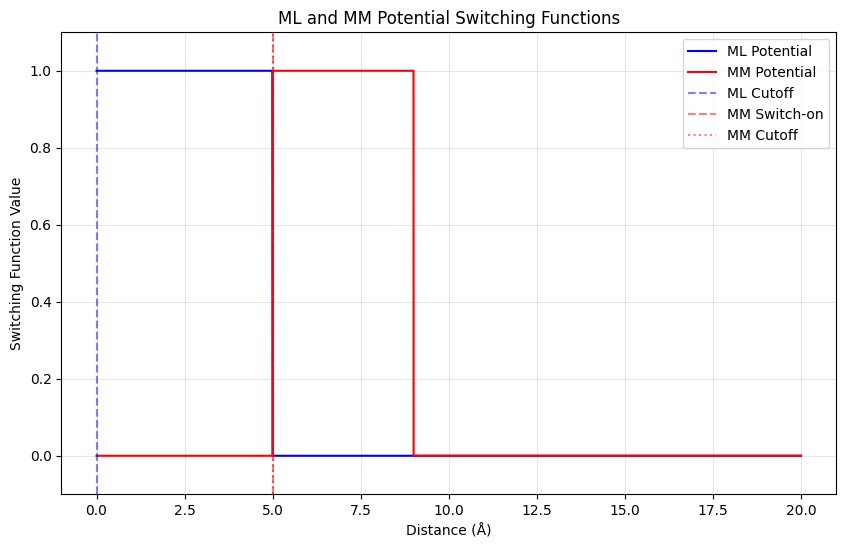

In [58]:
import matplotlib.pyplot as plt
fig = plot_cutoff_schemes(
    ml_cutoff=.001,
    mm_switch_on=5.0,
    mm_cutoff=.001
)
# plt.xlim(4.9, 5.2)
plt.show()

In [73]:
get_spherical_cutoff_calculator = setup_calculator(    
    ml_cutoff_distance=0.01,
    mm_switch_on=5.0,
    mm_cutoff=0.01,
    ep_scale=np.ones(161)*1
)

calculator, spherical_cutoff_calculator = get_spherical_cutoff_calculator(
    atomic_numbers[:10], 
     atom_positions[:10],    
    2,
    doML=True,
    doML_dimer=True,
    backprop=False,
    debug=False,
    # ep_scale=np.ones(161)*100000000

)

0 1


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm… │ epoch-996 │ 996   │ Array gpu:0 0.001 │ 2025-04-09 00:25:43.147267 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

ModelOutput(energy=Array gpu:0 -33.920, forces=Array[10, 3] n=30 x∈[-0.036, 0.035] μ=-5.122e-10 σ=0.016 gpu:0, dH=Array gpu:0 -0.233, internal_E=Array gpu:0 -33.454, internal_F=Array[10, 3] n=30 x∈[-1.618, 1.420] μ=3.974e-09 σ=0.730 gpu:0, mm_E=Array gpu:0 -0.233, mm_F=Array[10, 3] n=30 x∈[-0.036, 0.035] μ=-5.122e-10 σ=0.016 gpu:0, ml_2b_E=Array gpu:0 0., ml_2b_F=Array gpu:0 0.)

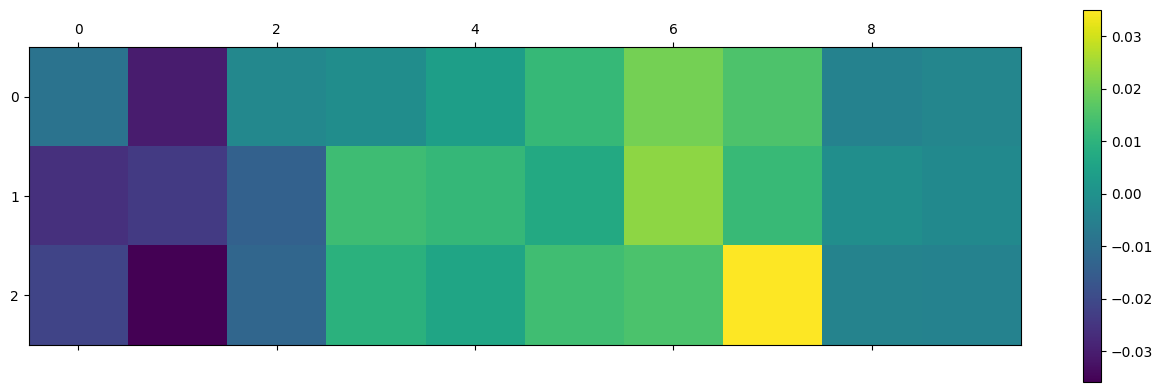

In [74]:
ase_atoms_with_calc = ase.Atoms(atomic_numbers[:10], atom_positions[:10] - atom_positions[:10].T.mean())
ase_atoms_with_calc.calc = calculator
print(ase_atoms_with_calc.get_potential_energy())
f1 = jnp.array(ase_atoms_with_calc.get_forces()).T
plt.matshow(f1)
plt.colorbar()
f1
ase_atoms_with_calc.calc.results["out"]

In [75]:
ase_atoms_with_calc.get_potential_energy()

Array gpu:0 -33.920

In [76]:
backprop_calculator, spherical_cutoff_calculator = get_spherical_cutoff_calculator(
    atomic_numbers[:10], 
     atom_positions[:10],    
    2,
    doML=True,
    doML_dimer=True,
    backprop=True,
    debug=False,
)

In [77]:
backprop_calculator

<__main__.setup_calculator.<locals>.AseDimerCalculator at 0x14d6da43fc80>

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

Array[3, 10] n=30 x∈[-1.603, 1.373] μ=0. σ=0.730 gpu:0

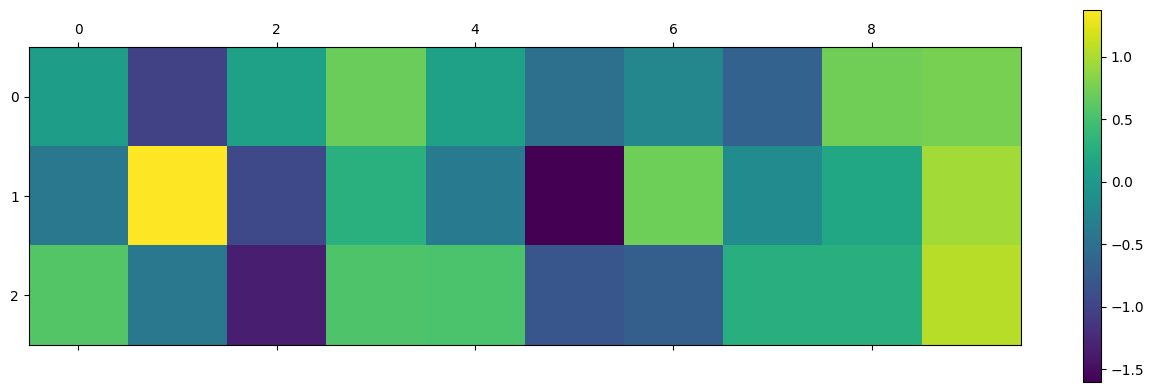

In [78]:
ase_atoms_with_bpcalc = ase.Atoms(atomic_numbers[:10], atom_positions[:10] - atom_positions[:10].T.mean())
ase_atoms_with_bpcalc.calc = backprop_calculator
f1 = jnp.array(ase_atoms_with_bpcalc.get_forces()).T
plt.matshow(f1)
plt.colorbar()
print(ase_atoms_with_bpcalc.get_potential_energy())
f1

In [79]:
ase_atoms_with_bpcalc.get_potential_energy()

Array gpu:0 -33.920

In [80]:
# xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
# coor.set_positions(xyz)
# energy.show()

In [81]:
backprop_calculator.get_potential_energy()

Array gpu:0 -33.920

In [82]:
# ase_atoms_with_calc = ase.Atoms(atomic_numbers, atom_positions - atom_positions.T.mean())
# ase_atoms_with_calc.calc = calculator
# print(ase_atoms_with_calc.get_potential_energy())

# df["filenames"] = df["key"].apply(lambda x: x.lower() + "_modified.pdb")
# df

# def add_out_pred(fn):
#     fn = data_path / "dcmk" / fn
#     pdb_data_mda = get_data_mda(fn)
#     atomic_numbers, atom_positions = (
#         pdb_data_mda["atomic_numbers"],
#         pdb_data_mda["atom_positions"],
#     )
    
#     ase_atoms_with_bpcalc.set_positions(atom_positions)
#     results = ase_atoms_with_calc.calc.results["out"]
#     return results

# all_output = {k: add_out_pred(k) for k in list(df["filenames"]) }


def plot_forces(results):
    print()
    f1 = jnp.array(results.mm_F).T
    plt.matshow(f1)
    plt.colorbar()
    print()
    f1 = jnp.array(results.internal_F).T
    plt.matshow(f1)
    print(results.energy)
    plt.colorbar()
    
    f1 = jnp.array(results.ml_2b_F).T
    plt.matshow(f1)
    plt.colorbar()
    
    f1 = jnp.array(results.forces).T
    plt.matshow(f1)
    plt.colorbar()

In [83]:
# print(ase_atoms_with_calc.get_potential_energy())



Array gpu:0 -33.920


ValueError: not enough values to unpack (expected 2, got 0)

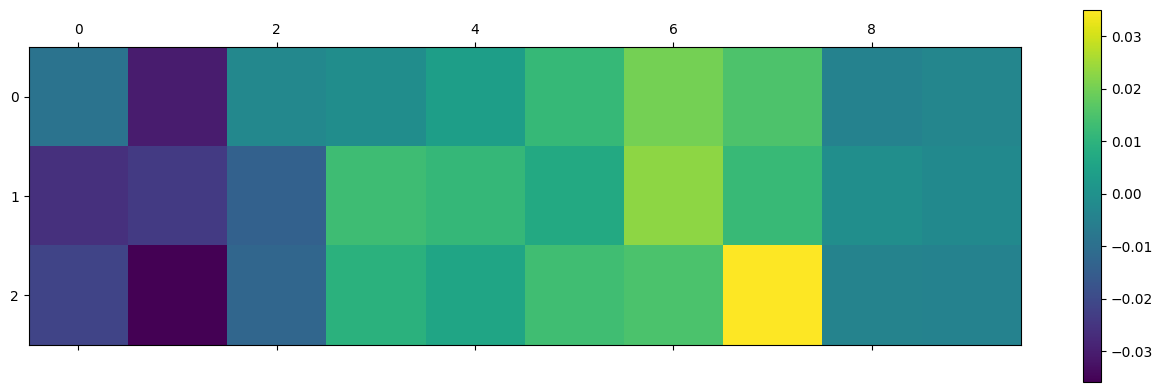

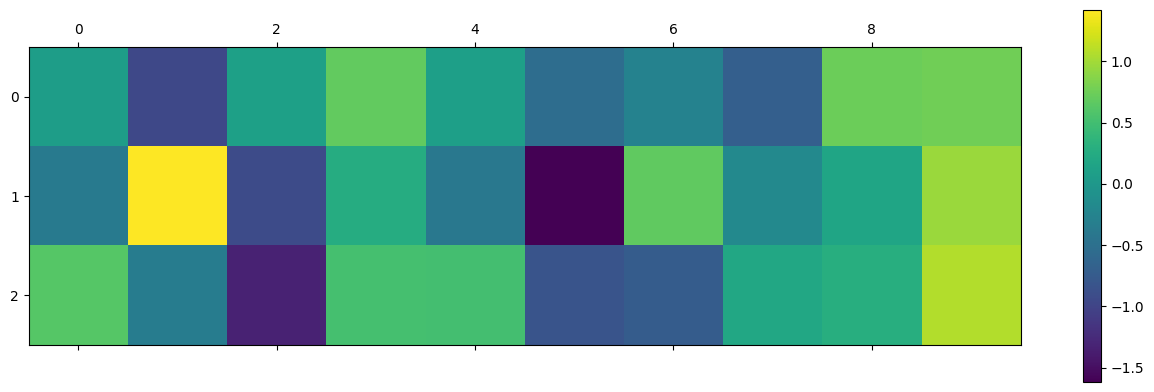

In [84]:
plot_forces(ase_atoms_with_calc.calc.results["out"])

In [ ]:
view_atoms(ase_atoms_with_calc)

In [ ]:
backprop_calculator.results

In [ ]:
# def add_e_pred(fn):
#     fn = data_path / "dcmk" / fn
#     pdb_data_mda = get_data_mda(fn)
#     atomic_numbers, atom_positions = (
#         pdb_data_mda["atomic_numbers"],
#         pdb_data_mda["atom_positions"],
#     )
    
#     ase_atoms_with_bpcalc.set_positions(atom_positions)
#     atomic_contribution = Eref[atomic_numbers].sum()
#     e_pred = ase_atoms_with_bpcalc.get_potential_energy()
#     e_pred = e_pred / ase.units.Hartree + atomic_contribution
#     return float(e_pred)

# df["cluster_energy_pred"] =  df["filenames"].apply(lambda x: add_e_pred(x))
# df

In [ ]:
# results = ase_atoms_with_calc.calc.results["out"]
# print(results)
# _ = (df["cluster_energy_pred"] - df["Cluster Energy"])*627.5
# _.mean()
# gt_z = (df["Cluster Energy"] - df["Cluster Energy"].mean())*627.5
# pred_z =  -(df["cluster_energy_pred"] - df["cluster_energy_pred"].mean())*627.5
# plt.scatter(gt_z, pred_z)
# ax  = plt.gca()
# # ax.transAxes
# plt.plot([0,1], [0,1], transform=ax.transAxes)
# ax.set_aspect("equal")
# # plt.xlim(df["cluster_energy_pred"].min(), df["cluster_energy_pred"].max())
# # plt.ylim(df["cluster_energy_pred"].min(), df["cluster_energy_pred"].max())

# DImers

In [86]:
dimers_data = np.load(Path("/pchem-data/meuwly/boittier/home/dcm_dimers_MP2_20999.npz"))
dimers_data["R"].shape

(20999, 10, 3)

In [87]:
# ase_atoms_with_calc.set_positions(dimers_data["R"][0])
# ase_atoms_with_calc.get_forces()
# results = ase_atoms_with_calc.calc.results["out"]
# print(results.forces)
# print(results.energy )
# print(results)
# print(ase_atoms_with_bpcalc.get_forces())
# print(ase_atoms_with_bpcalc.get_potential_energy())
?setup_calculator

Signature:
setup_calculator(
    ATOMS_PER_MONOMER: int = 5,
    N_MONOMERS: int = 2,
    ml_cutoff_distance: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    debug: bool = False,
    ep_scale=None,
    sig_scale=None,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_435843/1877199386.py
Type:      function

In [88]:
import seaborn as sns



def objective(x0, plot=False):
    print(x0)
    # [1, 66, 138]
    ep_scale = np.ones(161)
    sig_scale = np.ones(161)
    
    ep_scale[66] = x0[1]
    ep_scale[138] = x0[2]
    sig_scale[66] = x0[3]
    sig_scale[138] = x0[4]

    if plot:
        fig = plot_cutoff_schemes(
            ml_cutoff=0.01,
            mm_switch_on=x0[0],
            mm_cutoff=0.01
        )
        # plt.xlim(4.9, 5.2)
        plt.show()
    
    get_spherical_cutoff_calculator = setup_calculator(    
        ml_cutoff_distance=0.01,
        mm_switch_on=x0[0],
        mm_cutoff=0.01,
        ep_scale=ep_scale,
        sig_scale=sig_scale
    )
    
    backprop_calculator, spherical_cutoff_calculator = get_spherical_cutoff_calculator(
        atomic_numbers[:10], 
         atom_positions[:10],    
        2,
        doML=True,
        doML_dimer=True,
        backprop=True,
        debug=False,
    )
    
    ase_atoms_with_bpcalc.calc = backprop_calculator
    c = ase_atoms_with_bpcalc
    # c = ase_atoms_with_calc
    
    outs = []
    forces_pred = []
    forces_true = []
    distances = []
    energy_pred = []
    energy_true = []
    co = 0

    import random
    random.seed(42)
    # List of items
    mm_switch_on = x0[0]

    # Randomly select 2 items without repetition
    selected_items = list(range(len(dimers_data["Z"])))
    selected_items = [i for i in selected_items if dimers_data["Z"][i][5] != 0]
    selected_items = random.sample(selected_items, 100)
    # selected_items = [i for i in selected_items if dimers_data["Z"][i][5] != 0]
    for i in selected_items:       
        distance = np.linalg.norm(dimers_data["R"][i][:5].T.mean() - dimers_data["R"][i][5:].T.mean())
        if distance > mm_switch_on:
            co += 1
            c.set_positions(dimers_data["R"][i][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])
            distances.append([distance]*30)
            forces_true.append(jnp.array(dimers_data["F"][i]).flatten() )
            forces_pred.append(c.get_forces().flatten()  )
            Eref_add = Eref[c.get_atomic_numbers()].sum()
            energy_true.append([jnp.array(dimers_data["E"][i]).flatten()  ]*30)
            energy_pred.append([c.get_potential_energy()  ]*30)
            outs.append(c.calc.results["out"])
    
    
    r_key = "$r$"
    error_key = "error"
    se_key = "SE"
    abs_err_key = "abs$(error)$"
    F_true_key = "$F_{\\mathrm{True}}$"
    F_pred_key = "$F_{\\mathrm{pred}}$"
    absF_true_key = "abs($F_{\\mathrm{True}}$)"
    absF_pred_key = "abs($F_{\\mathrm{pred}}$)"
    epred_key = "Etrue"
    etrue_key = "Epred"
    
    __df__ = pd.DataFrame({r_key: np.array(distances).flatten(),
                           error_key: jnp.array(forces_pred).flatten() - jnp.array(forces_true).flatten(),
                           se_key: (jnp.array(forces_pred).flatten() - jnp.array(forces_true).flatten())**2,
                           abs_err_key: abs(jnp.array(forces_pred).flatten() - jnp.array(forces_true).flatten()), 
                          F_true_key : (jnp.array(forces_true).flatten()),
                          F_pred_key :  (jnp.array(forces_pred).flatten()), #(ase.units.kcal/ase.units.mol) ,
                          absF_true_key : abs(jnp.array(forces_true).flatten()),
                          absF_pred_key : abs(jnp.array(forces_pred).flatten()),
                          epred_key :np.array(energy_pred).flatten() - np.array(energy_pred).flatten().mean(),
                        etrue_key: np.array(energy_true).flatten() - np.array(energy_true).flatten().mean()
                          })



    
    if plot:    
        # Show the joint distribution using kernel density estimation
        g = sns.jointplot(
            data=__df__,
            x="Epred", y="Etrue", hue=r_key,
            # kind="kde",
        )
        
        plt.plot([-0.5,0.5], [-0.5,0.5], color="k", linestyle="--")
        plt.xlim(-0.5, 0.5)
        plt.ylim(-0.5, 0.5)
        
        
        
        # sns.regplot(
        #     data=__df__[__df__[r_key] < mm_switch_on],
        #     x=r_key, y=abs_err_key, 
        #     scatter=False, truncate=True, order=1, color=".2",
        # )
        
        plt.show()
        
        # Show the joint distribution using kernel density estimation
        g = sns.jointplot(
            data=__df__,
            x=r_key, y=abs_err_key, hue=absF_true_key,
            # kind="kde",
        )
        sns.regplot(
            data=__df__[__df__[r_key] < mm_switch_on],
            x=r_key, y=abs_err_key, 
            scatter=False, truncate=True, order=1, color=".2",
        )
        
        sns.regplot(
            data=__df__[__df__[r_key] > mm_switch_on],
            x=r_key, y=abs_err_key, 
            scatter=False, truncate=True, order=1, color=".3",
        )
        
        plt.xlim(0, 7)
        # plt.ylim(-2, 2)
        
        
        plt.show()
        
        
        
        g = sns.jointplot(
            data=__df__,
            x=r_key, y=F_true_key, hue=abs_err_key,
            # kind="kde",
        )
        
        sns.regplot(
            data=__df__,
            x=r_key, y=F_true_key,
            scatter=False, truncate=True, order=3, color=".2",
        )
        
        plt.show()
        
        g = sns.jointplot(
            data=__df__,
            x=F_true_key, y=F_pred_key, hue=r_key,
            alpha=0.5,
            # kind="kde",
        )
        
        plt.plot([-2,2], [-2, 2], color="k", linestyle="--", linewidth=0.5)
        
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        
        plt.show()

    
    loss = __df__[se_key].mean() * 3 + (((  __df__["Epred"] - __df__["Etrue"])**2).mean() * 30) * 3
    print(loss)
    print(co)
    print((__df__[se_key].mean())**0.5)
    print((((  __df__["Epred"] - __df__["Etrue"])**2).mean() * 30) ** 0.5)
    return loss


[6, 1, 1, 1, 1]


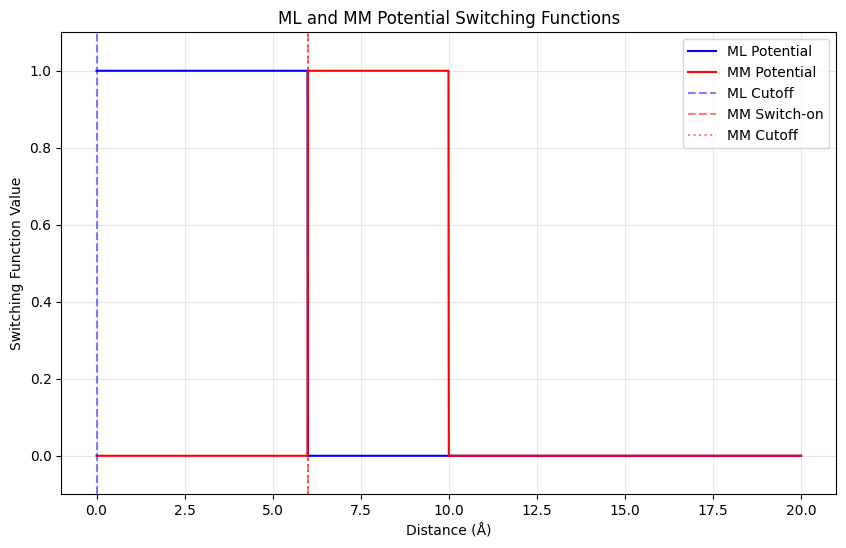

0 1


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm… │ epoch-996 │ 996   │ Array gpu:0 0.001 │ 2025-04-09 00:25:43.147267 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

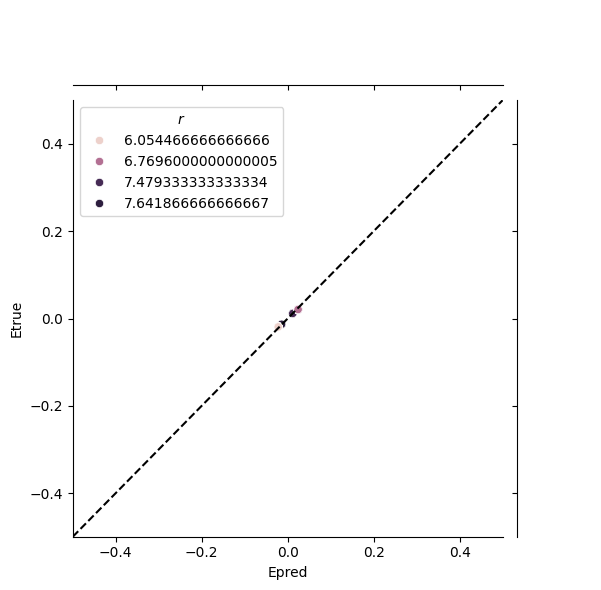

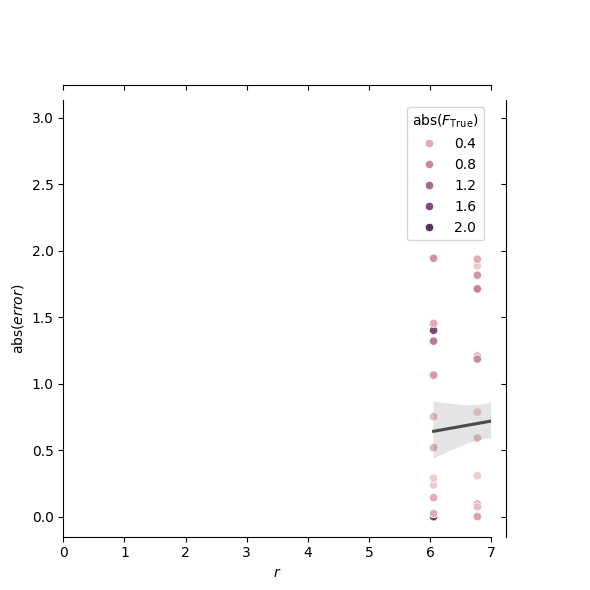

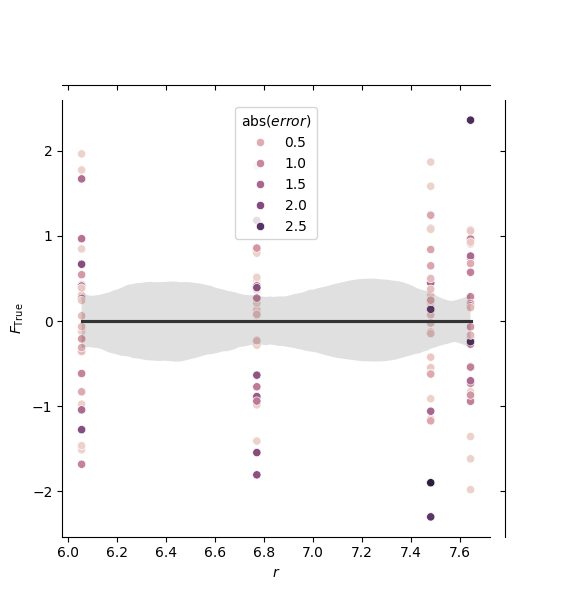

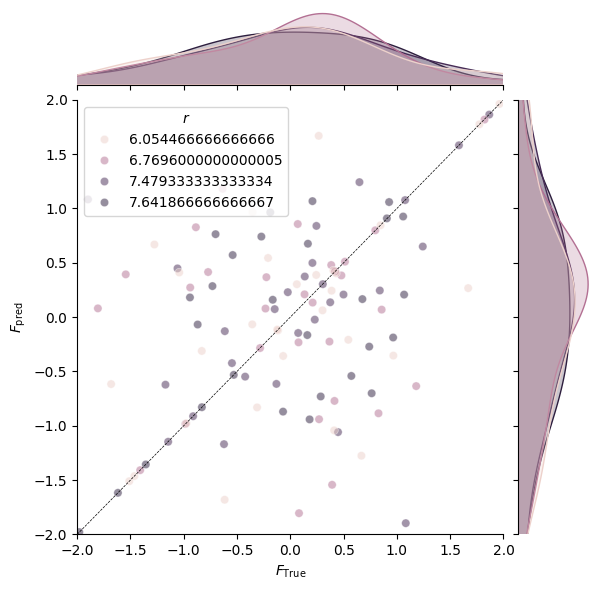

3.221887729082482
4
1.036244522098654
0.01264384361496126


3.221887729082482

In [89]:
objective([6, 1, 1, 1, 1], plot=True)


[4.00022052, 0.99998334, 0.999804, 1.09999745, 0.99998033]


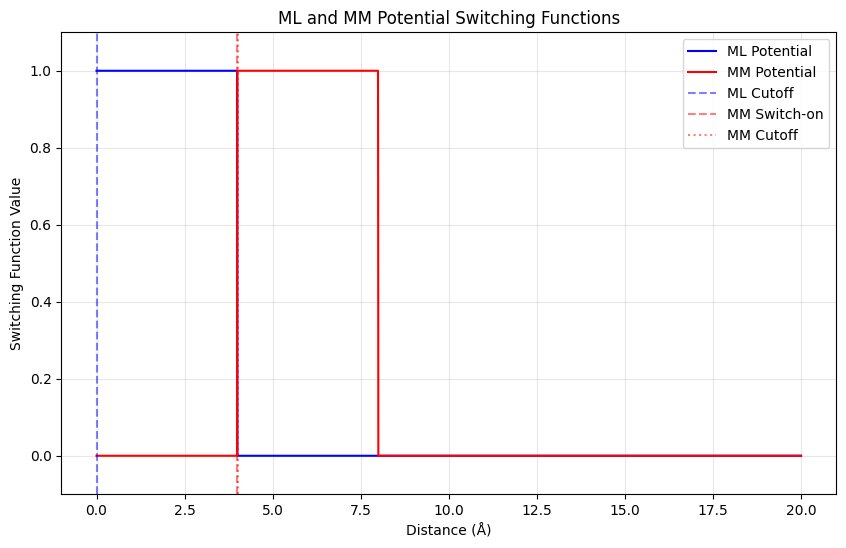

0 1


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm… │ epoch-996 │ 996   │ Array gpu:0 0.001 │ 2025-04-09 00:25:43.147267 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

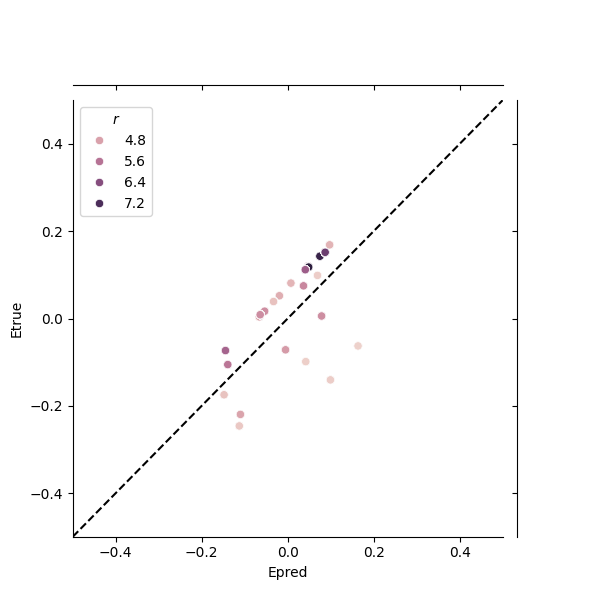

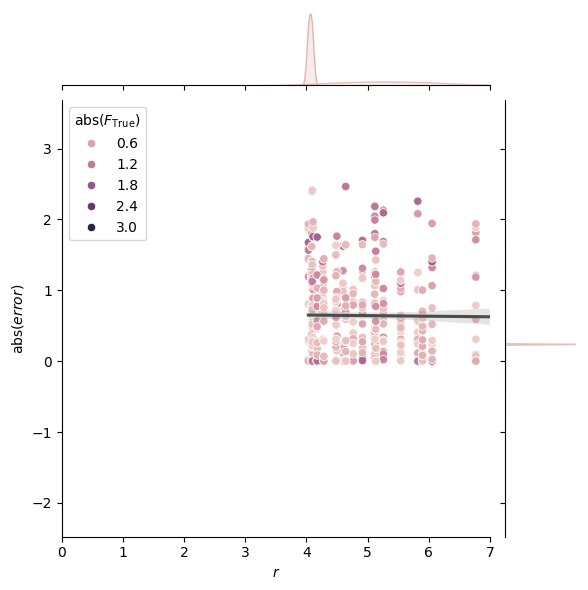

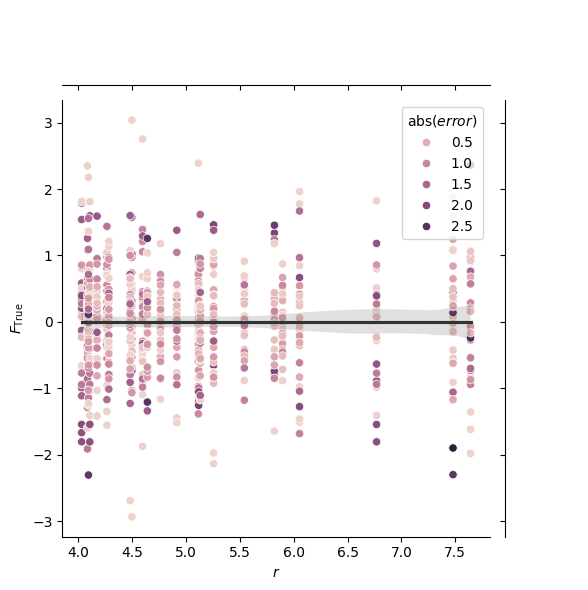

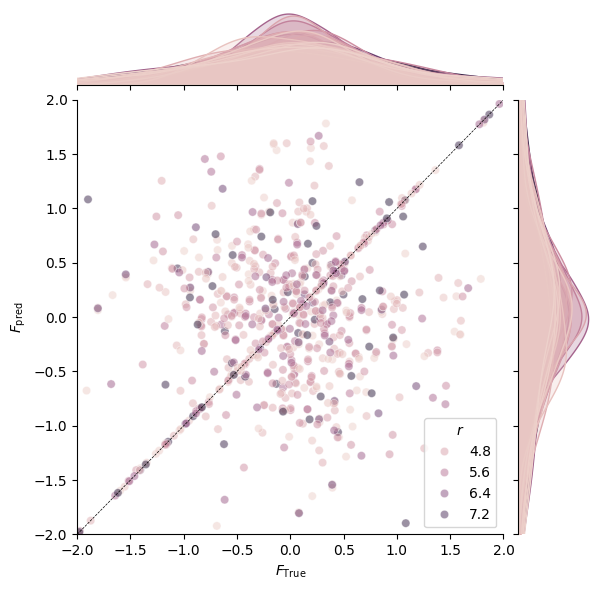

3.227265553548932
24
0.8826577042432445
0.5446747301430055


3.227265553548932

In [90]:
x0 = [4.00022052, 0.99998334, 0.999804,   1.09999745, 0.99998033]
objective(x0, plot=True)

In [ ]:
def create_initial_simplex(x0, delta=0.1):
    initial_simplex = np.zeros((len(x0) + 1, len(x0)))
    initial_simplex[0] = x0  # First point is x0
    for i in range(len(x0)):
        initial_simplex[i + 1] = x0.copy()
        initial_simplex[i + 1, i] += delta  # Add small step in dimension i
    return initial_simplex


def optimize_params_simplex(x0, bounds, 
loss, method="Nelder-Mead", maxiter=100, xatol=0.0001, fatol=0.0001):
    initial_simplex = create_initial_simplex(x0)
    res = minimize(
        loss,
        x0=x0,
        method="Nelder-Mead",
        bounds=bounds,
        options={
            "xatol": 0.001,  # Absolute tolerance on x
            "fatol": 0.001,  # Absolute tolerance on function value
            "initial_simplex": initial_simplex,
            "maxiter": 100,
        },
    )  # Initial simplex with steps of 0.0001

    print(res)
    return res
    
def get_bounds(x0, scale=0.9):
    b= [(x0[i] * (1-scale), x0[i] * (1+scale)) if x0[i] > 0 else (x0[i] * (1+scale), x0[i] * (1-scale)) 
    for i in range(len(x0)) ]
    return b

In [ ]:
x0 = [4,1,1,1,1]
bounds = get_bounds(x0)
bounds[0] = (2,6)
optimize_params_simplex(x0, get_bounds(x0), objective)

In [91]:
view_atoms(c)

NameError: name 'c' is not defined

In [92]:
# np.array(energy_true).flatten()[::30].mean()
# # Eref[]
__df__

NameError: name '__df__' is not defined

In [93]:
__df__.describe()

NameError: name '__df__' is not defined

In [94]:
s = plt.scatter(,
            , 
            facecolors='none', c=, alpha=0.5, cmap="plasma")

plt.colorbar(s)

SyntaxError: invalid syntax (1400000203.py, line 1)

In [95]:
len(distances)

NameError: name 'distances' is not defined

In [ ]:
for i in range(100):
    ase_atoms_with_bpcalc.set_positions(dimers_data["R"][-1*i][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])
    # ase_atoms_with_calc.set_positions(dimers_data["R"][i][[0, 3, 4, 1, 2, 5, 8, 9, 6, 7]])
    # plt.scatter(jnp.array(dimers_data["F"][i]).flatten(), ase_atoms_with_calc.get_forces().flatten(), color="k", alpha=1)
    plt.scatter(jnp.array(dimers_data["F"][i]).flatten(), ase_atoms_with_bpcalc.get_forces().flatten(), color="r", alpha=0.4)

In [1373]:
setup_calculator?

Signature:
setup_calculator(
    ATOMS_PER_MONOMER: int = 5,
    N_MONOMERS: int = 2,
    ml_cutoff_distance: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
    doML: bool = True,
    doMM: bool = True,
    doML_dimer: bool = True,
    debug: bool = False,
    ep_scale=None,
    sig_scale=None,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_387373/679687211.py
Type:      function

In [1372]:
import lovely_jax  as lj
lj.lovely(f1.T, depth=5)

Array[10, 3] n=30 x∈[-1.603, 1.373] μ=3.974e-09 σ=0.730 gpu:0
  Array[3] x∈[-0.416, 0.574] μ=0.070 σ=0.404 gpu:0 [0.052, -0.416, 0.574]
  Array[3] x∈[-1.025, 1.373] μ=-0.020 σ=1.017 gpu:0 [-1.025, 1.373, -0.409]
  Array[3] x∈[-1.351, 0.102] μ=-0.732 σ=0.613 gpu:0 [0.102, -0.946, -1.351]
  Array[3] x∈[0.286, 0.691] μ=0.508 σ=0.167 gpu:0 [0.691, 0.286, 0.548]
  Array[3] x∈[-0.376, 0.529] μ=0.085 σ=0.369 gpu:0 [0.101, -0.376, 0.529]
  Array[3] x∈[-1.603, -0.509] μ=-0.972 σ=0.463 gpu:0 [-0.509, -1.603, -0.803]
  Array[3] x∈[-0.700, 0.722] μ=-0.070 σ=0.592 gpu:0 [-0.231, 0.722, -0.700]
  Array[3] x∈[-0.671, 0.277] μ=-0.186 σ=0.387 gpu:0 [-0.671, -0.164, 0.277]
  Array[3] x∈[0.164, 0.732] μ=0.391 σ=0.246 gpu:0 [0.732, 0.164, 0.277]
  ...

In [96]:

# N_MONOMERS
get_spherical_cutoff_calculator = setup_calculator(    
    N_MONOMERS=20,
    ml_cutoff_distance=0.01,
    mm_switch_on=6.0,
    mm_cutoff=0.01,
    ep_scale=np.ones(161)*1
)

backprop_calculator, spherical_cutoff_calculator = get_spherical_cutoff_calculator(
    atomic_numbers, 
     atom_positions,    
    20,
    doML=True,
    doML_dimer=True,
    backprop=True,
    debug=False,
)

0 1
2 3
4 5
6 7
8 9
10 11
12 13
14 15
16 17
18 19


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1372: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


dict_keys(['opt_state', 'params', 'step'])


                                                 Model Attributes                                                  
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ charg… ┃ cutoff ┃ debug ┃ efa   ┃ featu… ┃ max_a… ┃ max_d… ┃ n_res ┃ natoms ┃ num_b… ┃ num_it… ┃ total… ┃ zbl   ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ False  │ 10.0   │ False │ False │ 128    │ 18     │ 0      │ 3     │ 10     │ 64     │ 5       │ 0      │ False │
└────────┴────────┴───────┴───────┴────────┴────────┴────────┴───────┴────────┴────────┴─────────┴────────┴───────┘

                                                  Last Checkpoint                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Checkpoint                                 ┃ name      ┃ epoch ┃ best_loss         ┃ Save Time                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ /pchem-data/meuwly/boittier/home/pycharmm… │ epoch-996 │ 996   │ Array gpu:0 0.001 │ 2025-04-09 00:25:43.147267 │
└────────────────────────────────────────────┴───────────┴───────┴───────────────────┴────────────────────────────┘

In [97]:
fn = data_path / "dcmk" / "100_lig_2_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
xyz = pd.DataFrame(atom_positions, columns=["x", "y", "z"])
coor.set_positions(xyz)
ase_atoms_with_bpcalc  =ase.Atoms(atomic_numbers,atom_positions)
ase_atoms_with_bpcalc.calc = backprop_calculator
# ase_atoms_with_bpcalc.set_positions(atom_positions)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


# Forces

In [98]:
# plt.set_cmap('jet')
# from ase.calculators.test import gradient_test
# f, fn = gradient_test(ase_atoms_with_bpcalc, indices=np.arange(0,10,1))
# plt.matshow(np.array(ase_atoms_with_bpcalc.get_forces()).T)
# plt.colorbar()
# plt.matshow((f - jnp.array(fn)).T)
# plt.colorbar()


  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

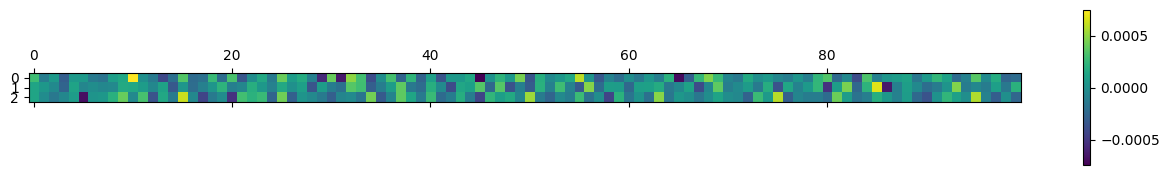

In [99]:
import ase.optimize as ase_opt
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(ase_atoms_with_bpcalc).run(fmax=0.001,steps=20)
plt.matshow(np.array(ase_atoms_with_bpcalc.get_forces()).T)
plt.colorbar()

In [100]:
# import ase.optimize as ase_opt
# ase_atoms_with_calc.set_positions(ase_atoms_with_bpcalc.get_positions())
# # Run structure optimization with BFGS.
# _ = ase_opt.BFGS(ase_atoms_with_calc).run(fmax=0.001,steps=20)
# plt.matshow(np.array(ase_atoms_with_calc.get_forces()).T)
# plt.colorbar()

In [101]:
view_atoms(ase_atoms_with_bpcalc)

In [102]:
# view_atoms(ase_atoms_with_calc)

In [103]:
# f, jnp.array(fn)
0.1 / 1000

0.0001

In [104]:
# view_atoms(ase_atoms_with_calc)

In [105]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [106]:
# Parameters.
temperature = 200.0
timestep_fs = 0.1
num_steps = 10_000

print(num_steps * timestep_fs / 1000, " ps")

atoms = ase_atoms_with_bpcalc

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 1000 == 0 and temperature < 300.0:
      temperature += i // 100
  else:
      temperature = 300.0
  if i % 1000 == 0:
      print(temperature)
      MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
      # Stationary(atoms)  # Remove center of mass translation.
  #     # ZeroRotation(atoms)  # Remove rotations.
  if i % 50 == 0:
      Stationary(atoms)  # Remove center of mass translation.
      print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

  if jnp.isnan(total_energy[i]) or total_energy[i] > 0:
      break



1.0  ps
200.0
step     0 epot -337.563 ekin  2.524 etot -335.039
step    50 epot -336.839 ekin  1.983 etot -334.856
step   100 epot -336.670 ekin  1.812 etot -334.858
step   150 epot -336.939 ekin  2.082 etot -334.858
step   200 epot -336.909 ekin  2.053 etot -334.856
step   250 epot -336.723 ekin  1.865 etot -334.857
step   300 epot -336.345 ekin  1.490 etot -334.855
step   350 epot -336.588 ekin  1.733 etot -334.855
step   400 epot -336.762 ekin  1.906 etot -334.855
step   450 epot -336.646 ekin  1.790 etot -334.856
step   500 epot -336.550 ekin  1.694 etot -334.856
step   550 epot -336.821 ekin  1.966 etot -334.855
step   600 epot -336.700 ekin  1.848 etot -334.853
step   650 epot -336.734 ekin  1.878 etot -334.856
step   700 epot -336.827 ekin  1.971 etot -334.856
step   750 epot -336.691 ekin  1.834 etot -334.857
step   800 epot -336.590 ekin  1.735 etot -334.855
step   850 epot -336.665 ekin  1.810 etot -334.855
step   900 epot -336.960 ekin  2.105 etot -334.855
step   950 epot -

In [120]:
# # Write structure to xyz file.
# xyz = io.StringIO()
# ase_io.write(xyz, atoms, format='xyz')

# # Visualize the structure with py3Dmol.
# view3d = py3Dmol.view()
# view3d.addModel(xyz.getvalue(), 'xyz')
# view3d.setStyle({'stick': {'radius': 0.05}, 'sphere': {'scale': 0.25}})
# # view3d.show()
# view3d.getModel().setCoordinates(frames[::10], 'array')
# view3d.animate({'loop': None, 'interval': 0.1})
# view3d.show()

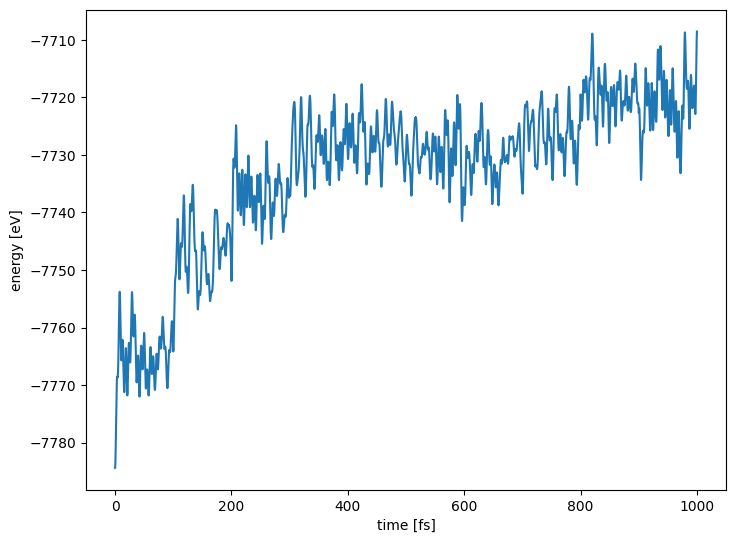

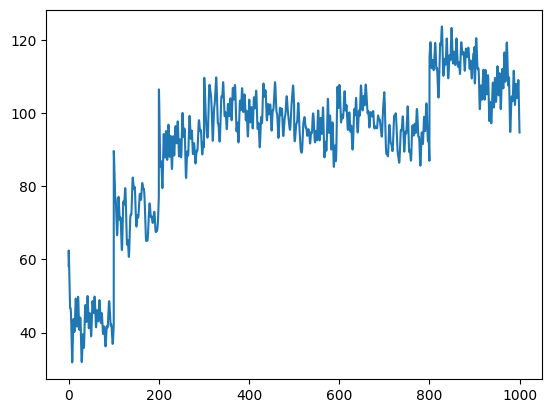

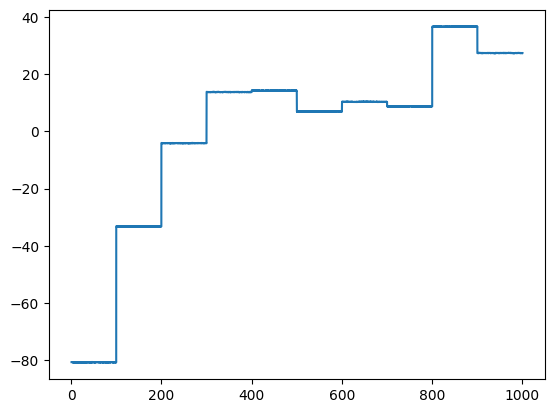

In [113]:
# %matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy/ (ase.units.kcal/ase.units.mol), label='potential energy')
plt.show()
plt.plot(time, kinetic_energy / (ase.units.kcal/ase.units.mol), label='kinetic energy')
plt.show()
te = total_energy / (ase.units.kcal/ase.units.mol)
te -= te.mean()
plt.plot(time[10:], te[10:], label='total energy')
# plt.ylim(0, 1000)
plt.show()
# plt.legend()
# plt.grid()

(array([  1.,   5.,  39., 116., 211., 319., 190.,  83.,  23.,   3.]),
 array([-0.00425532, -0.00345576, -0.0026562 , -0.00185664, -0.00105708,
        -0.00025752,  0.00054204,  0.0013416 ,  0.00214116,  0.00294072,
         0.00374028]),
 <BarContainer object of 10 artists>)

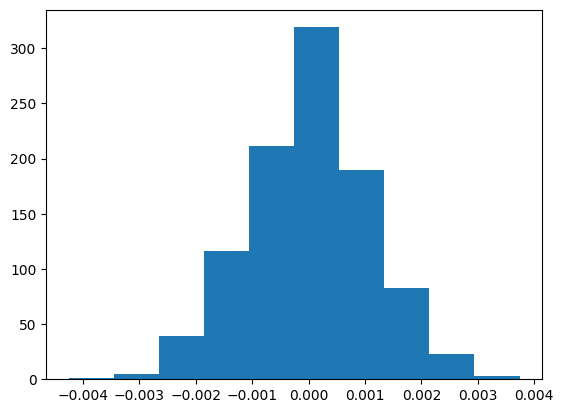

In [1424]:
plt.hist(total_energy[10:1000] - total_energy[10:1000].mean())

In [1432]:
# partition.neighbor_list?
    # ml_cutoff_distance=0.01,
    # mm_switch_on=6.0,
    # mm_cutoff=0.01,

CutoffParameters?

Init signature:
CutoffParameters(
    ml_cutoff: float = 2.0,
    mm_switch_on: float = 5.0,
    mm_cutoff: float = 1.0,
)
Docstring:      Parameters for ML and MM cutoffs and switching functions
Init docstring:
Args:
    ml_cutoff: Distance where ML potential is cut off
    mm_switch_on: Distance where MM potential starts switching on
    mm_cutoff: Final cutoff for MM potential
Type:           type
Subclasses:     

# JAX MD

In [468]:
from jax_md import partition
from jax_md import space
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax
from jax import ops

import time

from jax_md import space, smap, energy, minimize, quantity, simulate

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import jax_md
import numpy as np

from ase.io import read as ase_read
from jax_md import units
from typing import Dict

# from so3lr import to_jax_md
# from so3lr import So3lrPotential

import time





In [494]:
# Using float32 for positions / velocities, but float64 for reductions.
# dtype = np.float64

fn = data_path / "dcmk" / "100_lig_80_modified.pdb"

pdb_data_mda = get_data_mda(fn)
atomic_numbers, atom_positions = (
    pdb_data_mda["atomic_numbers"],
    pdb_data_mda["atom_positions"],
)
# xyz = pd.DataFrame(at

R = atom_positions #ase_atoms_with_bpcalc.get_positions()


@jit
def jax_md_energy_fn(position, **kwargs):
  l_nbrs = nbrs.update(jnp.array(position))
  return spherical_cutoff_calculator(position, atomic_numbers, n_monomers=20, cutoff_params=CutoffParameters()).energy #* (ase.units.kcal/ase.units.mol)

BOXSIZE = 30
displacement, shift = space.periodic(BOXSIZE, wrapped=False)
_, dummy_shift = space.free()
# CUTOFF = BOXSIZE/2
neighbor_fn = partition.neighbor_list(displacement, None, 30/2, format=partition.Sparse, dtype=jnp.float64)

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5191: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [495]:
nbrs = neighbor_fn.allocate(R)
# R.shape, R

In [496]:
jax_md_grad_fn = jax.grad(jax_md_energy_fn)

jax_md_energy_fn(R)

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

Array gpu:0 -334.582

In [497]:
jax_md_grad_fn(R)

Array[100, 3] n=300 (1.2Kb) x∈[-2.346, 2.541] μ=4.085e-07 σ=0.731 gpu:0

In [498]:
from jax_md import minimize

# init_fn, step_fn = minimize.fire_descent(jax_md_energy_fn, shift, dt_start=0.001, dt_max=0.001)
unwrapped_init_fn, unwrapped_step_fn = minimize.fire_descent(jax_md_energy_fn, shift, dt_start=0.001, dt_max=0.001)
unwrapped_step_fn = jit(unwrapped_step_fn)

In [499]:
try:
    del fire_state
except NameError:
    pass

fire_state = unwrapped_init_fn(R)

positions = []

for i in range(1000):

  positions += [fire_state.position]
  fire_state = jit(unwrapped_step_fn)(fire_state)

  if i % 100 == 0:
      print(i, float(jax_md_energy_fn(fire_state.position)), float(np.abs(np.array(jax_md_grad_fn(fire_state.position))).max()))

0 -334.58282470703125 2.540687084197998
100 -335.267822265625 2.082554817199707
200 -336.3533020019531 1.085610032081604
300 -337.0619201660156 0.7053488492965698
400 -337.4104919433594 0.37242990732192993
500 -337.4659729003906 0.5700389742851257
600 -337.49859619140625 0.36082589626312256
700 -337.5352478027344 0.17953252792358398
800 -337.5534973144531 0.06968457996845245
900 -337.5574035644531 0.12710171937942505


In [500]:
(positions[0] - positions[-1]).deeper

Array[100, 3] n=300 (1.2Kb) x∈[-0.108, 0.109] μ=1.603e-06 σ=0.038 gpu:0
  Array[3] x∈[-0.020, 0.015] μ=-0.002 σ=0.014 gpu:0 [-0.020, 0.015, -0.001]
  Array[3] x∈[-0.024, 0.039] μ=0.001 σ=0.027 gpu:0 [-0.012, 0.039, -0.024]
  Array[3] x∈[-0.063, -0.003] μ=-0.033 σ=0.024 gpu:0 [-0.063, -0.032, -0.003]
  Array[3] x∈[-0.039, 0.066] μ=0.022 σ=0.045 gpu:0 [0.066, -0.039, 0.039]
  Array[3] x∈[-0.011, 0.029] μ=0.012 σ=0.017 gpu:0 [0.029, 0.017, -0.011]
  Array[3] x∈[-0.005, 0.011] μ=0.002 σ=0.006 gpu:0 [0.011, -0.005, 0.001]
  Array[3] x∈[-0.040, 0.022] μ=-0.006 σ=0.026 gpu:0 [0.022, -0.040, 9.561e-05]
  Array[3] x∈[-0.044, 0.034] μ=-0.007 σ=0.032 gpu:0 [-0.044, 0.034, -0.013]
  Array[3] x∈[-0.059, 0.024] μ=-0.015 σ=0.034 gpu:0 [-0.059, 0.024, -0.011]
  ...

In [501]:
Z_ = atoms.get_atomic_numbers()
Z_comb = np.concatenate([Z_, Z_])
R_comb = np.stack([positions[0], positions[-1]], axis=0).reshape(200,3)
comb_atoms = ase.Atoms(Z_comb, R_comb)
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, comb_atoms, format='xyz')
# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [502]:
positions = fire_state.position
positions

Array[100, 3] n=300 (1.2Kb) x∈[-11.012, 17.411] μ=7.197 σ=7.154 gpu:0

In [503]:
# unit['temperature']
0.00005 * 1000

0.05

In [523]:

key = random.PRNGKey(0)
# dtype = np.float32
# Simulation parameters

timestep = 0.0001  # Time step in ps
nvt_cycles = 20 # Number of Cycles in the NPT.
nvt_steps = 100  # Number of NPT steps per cylce. The total number of MD steps equals npt_cylces * npt_steps

T_init = 10  # Initial temperature.
T_nvt = 300  # Target temperature. 

chain = 3  # Number of chains in the Nose-Hoover chain.
chain_steps = 2  # Number of steps per chain.
sy_steps = 3
thermo = 100 # * unit['temperature'] # Thermo value in the Nose-Hoover chain. 

# Set the temprature at initialization
if T_init is None:
    T_init = T_nvt 
else:
    T_init = T_init

# Dictionary with the NHC settings.
new_nhc_kwargs = {
    'chain_length': chain, 
    'chain_steps': chain_steps, 
    'sy_steps': sy_steps
}

# Convert to metal unit system.
unit = units.metal_unit_system()

timestep = timestep * unit['time']
T_init = T_init * unit['temperature']
T_nvt = T_nvt * unit['temperature']
rng_key = jax.random.PRNGKey(0)

# Some helper functions used throughout the example notebook.

# Default nose hoover chain parameters.
def default_nhc_kwargs(
    tau,
    overrides: Dict
) -> Dict:
    
    default_kwargs = {
        'chain_length': 3, 
        'chain_steps': 2, 
        'sy_steps': 3,
        # 'tau': tau
    }
    
    if overrides is None:
        return default_kwargs
  
    return {
      k: overrides.get(k, default_kwargs[k]) for k in default_kwargs
    }

/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:183: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


In [524]:
# partition.neighbor_list?

In [526]:
ase_atoms_with_bpcalc.set_positions(fire_state.position)
ase_atoms_with_bpcalc.set_cell([30., 30., 30.])
ase_atoms_with_bpcalc.wrap()
view_atoms(ase_atoms_with_bpcalc)

In [527]:
ase_atoms_with_bpcalc.get_potential_energy()

Array gpu:0 -337.558

In [528]:
box = None
displacement, shift = jax_md.space.free()
masses = ase_atoms_with_bpcalc.get_masses()

BOXSIZE = 30.0
displacement, shift = space.periodic_general(BOXSIZE, wrapped=False)
# _, dummy_shift = space.free()
CUTOFF = BOXSIZE/2


box = jnp.array(
    [
        np.array(ase_atoms_with_bpcalc.get_cell())[0, 0]
    ]
)  

print('box =', box)

fractional_coordinates = False
box = None
# displacement, shift = jax_md.space.periodic_general(box=box, fractional_coordinates=fractional_coordinates, wrapped=False)

# positions_init = jnp.array(atoms.get_positions())
# if fractional_coordinates:
    # positions_init = positions_init / box

# displacement, shift = jax_md.space.periodic_general(None, fractional_coordinates=fractional_coordinates) #, wrapped=False)
displacement, shift = space.periodic_general(BOXSIZE, wrapped=False)
neighbor_fn = partition.neighbor_list(displacement, box, CUTOFF, format=partition.Sparse, 
                                      fractional_coordinates=fractional_coordinates)



box = Array[1] gpu:0 [30.000]


/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5191: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)


In [529]:
# # neighbor_fn = partition.neighbor_list(
# #     displacement,
# #     0,
# #     1,  # load the cutoff of the model from the MLFFPotential
# #     1,
# #     1.2,
# #     1.2,  # as buffer_size_multiplier
# #     1,
# #     fractional_coordinates=False,
# #     format=partition.NeighborListFormat(1),  # only sparse is supported in mlff
# #     )

# neighbor_fn = partition.neighbor_list(displacement, None, CUTOFF*100, format=partition.Sparse,     fractional_coordinates=True)

# nbrs = neighbor_fn.allocate(
#     fire_state.position,
#     box=box
# )

In [530]:
try:
    del step_nvt_fn
except NameError:
    pass

@jax.jit
def step_nvt_fn(i, state):
    
    state, nbrs, box, temp_i = state

    state = apply_fn(
        state, 
        neighbor=nbrs.idx, 
        kT=temp_i,
        # box=box
    )
    
    nbrs = nbrs.update(
        state.position, 
        neighbor=nbrs.idx, 
    )
    
    return state, nbrs, box, temp_i

In [531]:
jax_md_energy_fn(ase_atoms_with_bpcalc.get_positions())

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

Array gpu:0 -337.558

In [532]:
# Track total time and step times averaged over cycle.
total_time = time.time()
positions_md = []

box = None # [30.0]
fractional_coordinates = False

try:
    del jax_md_energy_fn
except NameError:
    pass

@jit
def jax_md_energy_fn(position, **kwargs):
  # l_nbrs = nbrs.update(jnp.array(position))
  return spherical_cutoff_calculator(position, atomic_numbers, n_monomers=20, cutoff_params=CutoffParameters()).energy #/ (ase.units.kcal/ase.units.mol)

displacement, shift = space.periodic_general(BOXSIZE, wrapped=False)

# displacement, shift = jax_md.space.periodic_general(box=box, fractional_coordinates=fractional_coordinates, wrapped=False)
# Chosse Nose-Hoover thermostat.
init_fn, apply_fn = jax_md.simulate.nvt_nose_hoover(
    jax_md_energy_fn, 
    shift, 
    dt=timestep, 
    kT=T_init,
    # box=box,
    thermostat_kwargs=default_nhc_kwargs(jnp.array(thermo * timestep), new_nhc_kwargs)
)

apply_fn = jax.jit(apply_fn)
init_fn = jax.jit(init_fn)

# Initialize state using position and neigbhors structure relaxation.
state = init_fn(
    rng_key, 
    fire_state.position, 
    neighbor=nbrs.idx, 
    # box=box, 
    # neighbor_lr=nbrs_lr.idx,
    kT=T_init,
    mass=masses
)


print('Step\tKE\tPE\tTotal Energy\tTemperature\tH\ttime/steps')
print('-----------------------------------------------------------------------------------')
for i in range(3000):
    
    # print(temp_i)
    temp_i = 50.00 + i //10 # jnp.asarray(temp_i, dtype=jnp.float64)
    temp_i *= unit['temperature']
    # temp_i = 10.00 + i //20 
    old_time = time.time()
    # Do `nvt_steps` NVT steps.
    # box = jax.lax.stop_gradient(box)
    # kT = jax.lax.stop_gradient(kT)
    # mass = jax.lax.stop_gradient(mass)
    new_state,  nbrs, new_box, temp_i = jax.block_until_ready(
        jax.lax.fori_loop(
            0,
            nvt_steps,
            step_nvt_fn,
            (state,  nbrs, box, temp_i)  # carry state is tuple
        )
    )
    new_time = time.time()
    # Check for overflor of both sr and lr neighbors.
    # if nbrs.did_buffer_overflow:
    #     print('Neighbor list overflowed, reallocating.')
    #     nbrs = neighbor_fn.allocate(state.position, box = box)
        # if nbrs_lr.did_buffer_overflow:
        #     print('Long-range neighbor list also overflowed, reallocating.')
        #     nbrs_lr = neighbor_fn_lr.allocate(state.position, box = box)
    # else:
    state = new_state
    box = new_box
    
    # Calculate some quantities for printing
    KE = jax_md.quantity.kinetic_energy(
        momentum=state.momentum,
        mass=state.mass
    )
    PE = jax_md_energy_fn(
        state.position,
        neighbor=nbrs.idx,
        # neighbor_lr=nbrs_lr.idx, 
        # box=box
    )
    T = jax_md.quantity.temperature(
        momentum=state.momentum,
        mass = state.mass
    ) / unit['temperature']
    
    H = jax_md.simulate.nvt_nose_hoover_invariant(
        jax_md_energy_fn, 
        state, 
        kT=temp_i,
        neighbor=nbrs.idx,
        # neighbor_lr=nbrs_lr.idx, 
        # box=box
    )
    print(f'{i*nvt_steps}\t{KE:.2f}\t{float(PE):.2f}\t{float(KE+PE):.3f}\t{float(T):.1f}\t{float(H):.3f}\t{(new_time - old_time) / nvt_steps:.4f}')
    
    # if jnp.isnan(KE):
    #     break

    positions_md.append(np.array(state.position))
    # if jnp.isnan(KE):
    #     break

print('Total_time: ', time.time()-total_time)

  
 CHARMM>     read rtf card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf
 VOPEN> Attempting to open::/pchem-data/meuwly/boittier/home/charmm/toppar/top_all36_cgenff.rtf::
 MAINIO> Residue topology file being read from unit  91.
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *          CGENFF: TOPOLOGY FOR THE CHARMM GENERAL FORCE FIELD V. 4.6          *
 TITLE> *                    FOR SMALL MOLECULE DRUG DESIGN                            *
 TITLE> *  --------------------------------------------------------------------------  *
 TITLE> *

 DRUDES PARTICLES WILL BE GENERATED AUTOMATICALLY FOR ALL ATOMS WITH NON-ZERO ALPHA
 Thole-type dipole screening, Slater-Delta shape {S(u) = 1 - (1+u/2)*exp(-u)}, default radius =  1.300000
 VCLOSE: Closing unit   91 with status "KEEP"
  
 CHARMM>     
  
  
 CHARMM>     read param card -
 CHARMM>     name /pchem-data/meuwly/boittier/home/charmm/toppar/par_a

In [516]:
Z_ = ase_atoms_with_bpcalc.get_atomic_numbers()
Z_comb = np.concatenate([Z_, Z_])
R_comb = np.stack([fire_state.position, positions_md[-1]], axis=0).reshape(200,3)
comb_atoms = ase.Atoms(Z_comb, R_comb)
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, comb_atoms, format='xyz')
# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [533]:
ase_atoms_with_bpcalc.set_positions(fire_state.position)
# ase_atoms_with_bpcalc.set_cell([30., 30., 30.])
# ase_atoms_with_bpcalc.wrap()
view_atoms(ase_atoms_with_bpcalc)

In [534]:
state

NVTNoseHooverState(position=Array[100, 3] n=300 (1.2Kb) x∈[-13.880, 19.884] μ=7.203 σ=7.620 gpu:0, momentum=Array[100, 3] n=300 (1.2Kb) x∈[-3.979, 2.974] μ=-0.005 σ=0.859 gpu:0, force=Array[100, 3] n=300 (1.2Kb) x∈[-0.308, 0.249] μ=-7.472e-07 σ=0.084 gpu:0, mass=Array[100, 1] x∈[1.008, 35.450] μ=16.985 σ=15.602 gpu:0, chain=NoseHooverChain(position=Array[5] x∈[-17.149, 93.864] μ=24.072 σ=42.511 gpu:0 [-2.061, -6.980, 93.864, -17.149, 52.686], momentum=Array[5] x∈[-0.188, 0.029] μ=-0.041 σ=0.077 gpu:0 [-0.188, -0.033, 0.001, -0.014, 0.029], mass=Array[5] x∈[0.029, 8.705] μ=1.764 σ=3.470 gpu:0 [8.705, 0.029, 0.029, 0.029, 0.029], tau=Array gpu:0 0.982, kinetic_energy=Array gpu:0 4.589, degrees_of_freedom=300))

In [535]:
Z_ = atoms.get_atomic_numbers()
Z_comb = np.concatenate([Z_])
R_comb = np.stack([positions_md[-1]], axis=0).reshape(100,3)
comb_atoms = ase.Atoms(Z_comb, R_comb)
# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, comb_atoms, format='xyz')
# Visualize the structure with py3Dmol.
view3d = py3Dmol.view()
view3d.addModel(xyz.getvalue(), 'xyz')
view3d.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view3d.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [536]:
# Save the frames to xyz.
from ase.io import write
from ase import Atoms
atoms_traj = []


import os
os.remove("nvt_md_trajectory.xyz")

for positions in positions_md:
    atoms_traj.append(
        Atoms(numbers=np.array(atomic_numbers), positions=positions),
    )


for frame in atoms_traj:
    write( 
        'nvt_md_trajectory.xyz',
        frame,
        append=True
    )

In [521]:
np.linalg.norm(positions_md[-1] - positions_md[0])

4.6723347

In [522]:
len(atoms_traj)

107